## Getting connected and fetching data

In [8]:
#getting connected with the data
import os
import pymysql
import pandas as pd

host = os.getenv('MYSQL_HOST')
port = os.getenv('MYSQL_PORT')
user = os.getenv('MYSQL_USER')
password = os.getenv('MYSQL_PASSWORD')
database = os.getenv('MYSQL_DATABASE')

conn = pymysql.connect(
    host='3.6.71.112',
    port=int(3306),
    user="datauser",
    passwd='DBroPrODuser@123',
    db="danbro_aggregation_db",
    charset='utf8mb4')

In [9]:
print(conn)

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import numpy as np
import seaborn as sn
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [4]:
query="SELECT TXN_ID, TXN_DATE from Invoice where TXN_STATUS='Completed'"
cursor = conn.cursor()
data=cursor.execute(query)
trans_data = pd.DataFrame(cursor.fetchall())

In [5]:
trans_data.columns = ['TXN_ID','TXN_DATE']
trans_data

,TXN_ID,TXN_DATE
0,1001000595200,2019-01-01
1,1001000595201,2019-01-01
2,1001000595202,2019-01-01
3,1001000595203,2019-01-01
4,1001000595204,2019-01-01
...,...,...
2547789,1018001760155,2018-12-31
2547790,1018001760156,2018-12-31
2547791,1018001760157,2018-12-31
2547792,1018001760158,2018-12-31


In [6]:
trans_data['TXN_DATE'].min(),trans_data['TXN_DATE'].max()

(Timestamp('2017-07-01 00:00:00'), Timestamp('2020-08-31 00:00:00'))

In [10]:

query="select TXN_ID , PRODUCT_NAME, PRODUCT_QUANTITY, PRODUCT_SKU from Products_2"
cursor = conn.cursor()
data=cursor.execute(query)
prod_data = pd.DataFrame(cursor.fetchall())

In [12]:
prod_data.columns = ['TXN_ID','PRODUCT_NAME','PRODUCT_QUANTITY','PRODUCT_SKU']
prod_data

,TXN_ID,PRODUCT_NAME,PRODUCT_QUANTITY,PRODUCT_SKU
0,1001000595200,(AMUL) BUTTER (100G),1.0,2279
1,1001000595200,(MB) BREAD FAMILY,1.0,29
2,1001000595201,(MB) BREAD FAMILY,1.0,29
3,1001000595201,(MB) BREAD OAT MEAL,1.0,52
4,1001000595202,(AMUL) BUTTER (100G),1.0,2279
...,...,...,...,...
5237932,3091708,(MB) CHOCO BADAAM (ALMOND) (PCS),1.0,1015
5237933,3092057,(MB) COOKIES DRY FRUIT,1.0,3822
5237934,3092057,(MB) COOKIES CHOCO CHIP,1.0,3808
5237935,3092057,(MB) COOKIES NO ADDED SUGAR MULTIGRAIN,2.0,3861


In [13]:
prod_data.PRODUCT_NAME.nunique()

3268

In [14]:
prod_data.PRODUCT_SKU.nunique()

3466

### MERGING DATA  on TXN_ID

In [15]:
data = pd.merge(trans_data, prod_data, on='TXN_ID')
data

,TXN_ID,TXN_DATE,PRODUCT_NAME,PRODUCT_QUANTITY,PRODUCT_SKU
0,1001000595200,2019-01-01,(AMUL) BUTTER (100G),1.0,2279
1,1001000595200,2019-01-01,(MB) BREAD FAMILY,1.0,29
2,1001000595201,2019-01-01,(MB) BREAD FAMILY,1.0,29
3,1001000595201,2019-01-01,(MB) BREAD OAT MEAL,1.0,52
4,1001000595202,2019-01-01,(AMUL) BUTTER (100G),1.0,2279
...,...,...,...,...,...
5238059,1018001760157,2018-12-31,(MB) COOKIES CAKE RUSK,1.0,3803
5238060,1018001760157,2018-12-31,(MB) COOKIES COCONUT MACROONS,1.0,3814
5238061,1018001760158,2018-12-31,(MB) CHOCO BAR DAIRY MILK,1.0,997
5238062,1018001760159,2018-12-31,(MB) CHOCO BAR DAIRY MILK,1.0,997


### Checking duplicates and removing them

In [16]:
duplicate = data.duplicated()
print(duplicate.sum())

8114


In [17]:
duplicateDFRow = data[data.duplicated()]
print(duplicateDFRow)

                TXN_ID   TXN_DATE  \
492      1001000595487 2019-01-01   
915      1001000595702 2019-01-01   
2524     1001000596597 2019-01-01   
2526     1001000596597 2019-01-01   
2898     1001000596795 2019-01-01   
...                ...        ...   
5235108  1018001150056 2018-10-30   
5235754  1018001280090 2018-11-13   
5237511  1018001670116 2018-12-22   
5237644  1018001700133 2018-12-25   
5237784  1018001720140 2018-12-27   

                                           PRODUCT_NAME  PRODUCT_QUANTITY  \
492                        (MB) CUSTARD CHOCOLATE (E/L)              2.00   
915      (DIZZLE) MOUTH FRESHENER SATRANGREE MIX (200G)              0.50   
2524                        (MB) PASTRY REDVELVET (E/L)              1.00   
2526                        (MB) PASTRY CHOCOLATE (E/L)              1.00   
2898                            (MB) COOKIES JEERA PUFF              0.25   
...                                                 ...               ...   
5235108        4

In [29]:
# we see the duplicates are not like full row is duplicated so no need to remove these..


### Checking NA values and removing them

In [18]:
## checking for NA Values
na_values = pd.isna(data) # Boolean DataFrame
na_features = na_values.any() # Boolean Series
print(na_features)

TXN_ID              False
TXN_DATE            False
PRODUCT_NAME        False
PRODUCT_QUANTITY    False
PRODUCT_SKU         False
dtype: bool


In [31]:
##There is no NA value in the dataset

### checking null values

In [19]:
## checking null values
data.isnull().sum()

TXN_ID              0
TXN_DATE            0
PRODUCT_NAME        0
PRODUCT_QUANTITY    0
PRODUCT_SKU         0
dtype: int64

In [ ]:
## there is no null value in the dataset

In [20]:
data

,TXN_ID,TXN_DATE,PRODUCT_NAME,PRODUCT_QUANTITY,PRODUCT_SKU
0,1001000595200,2019-01-01,(AMUL) BUTTER (100G),1.0,2279
1,1001000595200,2019-01-01,(MB) BREAD FAMILY,1.0,29
2,1001000595201,2019-01-01,(MB) BREAD FAMILY,1.0,29
3,1001000595201,2019-01-01,(MB) BREAD OAT MEAL,1.0,52
4,1001000595202,2019-01-01,(AMUL) BUTTER (100G),1.0,2279
...,...,...,...,...,...
5238059,1018001760157,2018-12-31,(MB) COOKIES CAKE RUSK,1.0,3803
5238060,1018001760157,2018-12-31,(MB) COOKIES COCONUT MACROONS,1.0,3814
5238061,1018001760158,2018-12-31,(MB) CHOCO BAR DAIRY MILK,1.0,997
5238062,1018001760159,2018-12-31,(MB) CHOCO BAR DAIRY MILK,1.0,997


In [21]:
data.describe()

,TXN_ID,PRODUCT_QUANTITY,PRODUCT_SKU
count,5.238064e+06,5.238064e+06,5.238064e+06
mean,9.124409e+11,1.578550e+00,1.568197e+03
std,2.868256e+11,4.917743e+00,3.161183e+03
min,3.068426e+06,0.000000e+00,1.000000e+00
25%,1.001000e+12,1.000000e+00,2.880000e+02
50%,1.002000e+12,1.000000e+00,7.610000e+02
75%,1.003000e+12,2.000000e+00,1.200000e+03
max,1.037000e+12,2.500000e+03,2.254600e+04


### Removing unnecceasry rows(conditionally)

In [22]:
# rows with ZERO product quantity should be removed so,
data[data['PRODUCT_QUANTITY']==0]

,TXN_ID,TXN_DATE,PRODUCT_NAME,PRODUCT_QUANTITY,PRODUCT_SKU
20368,1001000605754,2019-01-11,(MB) COOKIES JEERA BISCUIT,0.0,426
62874,1001000626654,2019-02-03,(MB) CL CAKE CHOCO E/G,0.0,839
154584,1001000671322,2019-03-19,4777 : (VEEBA) OLIVE OIL MAYONAISE 300GM,0.0,4777
159036,1001000673341,2019-03-20,(MB) COOKIES MIXED DRY FRUIT,0.0,437
177062,1001000682718,2019-03-31,(MB) PASTRY PINEAPPLE MINI (E/G),0.0,4806
...,...,...,...,...,...
4141673,1001000561837,2018-12-01,(MB) TOAST GARLIC AND HERB,0.0,5112
4272534,1002000200907,2018-02-26,(MB) SWEET GUJIA REGULAR,0.0,288
4272535,1002000200907,2018-02-26,(MB) BREAD SANDWICH SMALL,0.0,384
4272559,1002000200921,2018-02-26,(MB) SANDWICH VEG CHEESE,0.0,764


In [23]:
data.drop(data[data['PRODUCT_QUANTITY'] ==0].index, inplace = True)

In [24]:
data.describe()

,TXN_ID,PRODUCT_QUANTITY,PRODUCT_SKU
count,5.237993e+06,5.237993e+06,5.237993e+06
mean,9.124397e+11,1.578572e+00,1.568184e+03
std,2.868274e+11,4.917773e+00,3.161154e+03
min,3.068426e+06,1.000000e-02,1.000000e+00
25%,1.001000e+12,1.000000e+00,2.880000e+02
50%,1.002000e+12,1.000000e+00,7.610000e+02
75%,1.003000e+12,2.000000e+00,1.200000e+03
max,1.037000e+12,2.500000e+03,2.254600e+04


In [25]:
train = data
# data extraction
train['Year'] = train['TXN_DATE'].dt.year
train['Month'] = train['TXN_DATE'].dt.month
train['Day'] = train['TXN_DATE'].dt.day
train['Day Of Year'] = train['TXN_DATE'].dt.dayofyear

train

,TXN_ID,TXN_DATE,PRODUCT_NAME,PRODUCT_QUANTITY,PRODUCT_SKU,Year,Month,Day,Day Of Year
0,1001000595200,2019-01-01,(AMUL) BUTTER (100G),1.0,2279,2019,1,1,1
1,1001000595200,2019-01-01,(MB) BREAD FAMILY,1.0,29,2019,1,1,1
2,1001000595201,2019-01-01,(MB) BREAD FAMILY,1.0,29,2019,1,1,1
3,1001000595201,2019-01-01,(MB) BREAD OAT MEAL,1.0,52,2019,1,1,1
4,1001000595202,2019-01-01,(AMUL) BUTTER (100G),1.0,2279,2019,1,1,1
...,...,...,...,...,...,...,...,...,...
5238059,1018001760157,2018-12-31,(MB) COOKIES CAKE RUSK,1.0,3803,2018,12,31,365
5238060,1018001760157,2018-12-31,(MB) COOKIES COCONUT MACROONS,1.0,3814,2018,12,31,365
5238061,1018001760158,2018-12-31,(MB) CHOCO BAR DAIRY MILK,1.0,997,2018,12,31,365
5238062,1018001760159,2018-12-31,(MB) CHOCO BAR DAIRY MILK,1.0,997,2018,12,31,365


In [26]:
train =  train[train['Day Of Year'].isin([1,2,3,357,358,359,360,361,362,363,364,365])]  


In [27]:
train

,TXN_ID,TXN_DATE,PRODUCT_NAME,PRODUCT_QUANTITY,PRODUCT_SKU,Year,Month,Day,Day Of Year
0,1001000595200,2019-01-01,(AMUL) BUTTER (100G),1.0,2279,2019,1,1,1
1,1001000595200,2019-01-01,(MB) BREAD FAMILY,1.0,29,2019,1,1,1
2,1001000595201,2019-01-01,(MB) BREAD FAMILY,1.0,29,2019,1,1,1
3,1001000595201,2019-01-01,(MB) BREAD OAT MEAL,1.0,52,2019,1,1,1
4,1001000595202,2019-01-01,(AMUL) BUTTER (100G),1.0,2279,2019,1,1,1
...,...,...,...,...,...,...,...,...,...
5238059,1018001760157,2018-12-31,(MB) COOKIES CAKE RUSK,1.0,3803,2018,12,31,365
5238060,1018001760157,2018-12-31,(MB) COOKIES COCONUT MACROONS,1.0,3814,2018,12,31,365
5238061,1018001760158,2018-12-31,(MB) CHOCO BAR DAIRY MILK,1.0,997,2018,12,31,365
5238062,1018001760159,2018-12-31,(MB) CHOCO BAR DAIRY MILK,1.0,997,2018,12,31,365


###  100 most important Brands by quantity across 3 years 

In [28]:

top = train.groupby(["PRODUCT_NAME","PRODUCT_SKU"])["PRODUCT_QUANTITY"].sum().nlargest(200).reset_index()
top

,PRODUCT_NAME,PRODUCT_SKU,PRODUCT_QUANTITY
0,(MB) BURGER VEGGIE,761,26013.0
1,(MB) PATTY AALOO VEG,721,11628.0
2,(MB) BURGER VEGGIE CHEESE,762,8698.0
3,(MB) BREAD MILK,48,7214.0
4,(MB) PASTRY PINEAPPLE (E/L),1172,6872.0
...,...,...,...
195,CAKE BUTTERSCOTCH (E/L),474,318.0
196,(DB) RUSK NO ADDED SUGAR SWEET,1121,317.0
197,(MB) NAMKEEN LACCHA AALOO PLAIN,875,317.0
198,CAKE PINEAPPLE (E/G),510,315.0


In [38]:
top[top["PRODUCT_NAME"]=="(MB) BURGER VEGGIE"]

,PRODUCT_NAME,PRODUCT_SKU,PRODUCT_QUANTITY
0,(MB) BURGER VEGGIE,761,26013.0


In [31]:
df = train
df.drop(['PRODUCT_NAME'],axis=1, inplace=True)
df

,TXN_ID,TXN_DATE,PRODUCT_QUANTITY,PRODUCT_SKU,Year,Month,Day,Day Of Year
0,1001000595200,2019-01-01,1.0,2279,2019,1,1,1
1,1001000595200,2019-01-01,1.0,29,2019,1,1,1
2,1001000595201,2019-01-01,1.0,29,2019,1,1,1
3,1001000595201,2019-01-01,1.0,52,2019,1,1,1
4,1001000595202,2019-01-01,1.0,2279,2019,1,1,1
...,...,...,...,...,...,...,...,...
5238059,1018001760157,2018-12-31,1.0,3803,2018,12,31,365
5238060,1018001760157,2018-12-31,1.0,3814,2018,12,31,365
5238061,1018001760158,2018-12-31,1.0,997,2018,12,31,365
5238062,1018001760159,2018-12-31,1.0,997,2018,12,31,365


### Sorting data on dates 

In [32]:
df.drop(['TXN_ID'], axis=1, inplace=True)
df = df.sort_values('TXN_DATE')
df

,TXN_DATE,PRODUCT_QUANTITY,PRODUCT_SKU,Year,Month,Day,Day Of Year
3446081,2017-12-23,3.0,762,2017,12,23,357
3287592,2017-12-23,4.0,1174,2017,12,23,357
3287593,2017-12-23,1.0,48,2017,12,23,357
3287594,2017-12-23,1.0,1209,2017,12,23,357
3287595,2017-12-23,1.0,132,2017,12,23,357
...,...,...,...,...,...,...,...
2485496,2020-01-03,1.5,523,2020,1,3,3
2485495,2020-01-03,1.0,5013,2020,1,3,3
2485494,2020-01-03,1.0,838,2020,1,3,3
2485505,2020-01-03,1.5,474,2020,1,3,3


In [33]:
m = df.PRODUCT_SKU.isin(top.PRODUCT_SKU)  ##Filtering only the PRODUCT_SKU which is present in topProducts
m

3446081     True
3287592     True
3287593     True
3287594     True
3287595     True
           ...  
2485496    False
2485495    False
2485494    False
2485505     True
2733046    False
Name: PRODUCT_SKU, Length: 219916, dtype: bool

In [34]:
df = df[m]
df

,TXN_DATE,PRODUCT_QUANTITY,PRODUCT_SKU,Year,Month,Day,Day Of Year
3446081,2017-12-23,3.0,762,2017,12,23,357
3287592,2017-12-23,4.0,1174,2017,12,23,357
3287593,2017-12-23,1.0,48,2017,12,23,357
3287594,2017-12-23,1.0,1209,2017,12,23,357
3287595,2017-12-23,1.0,132,2017,12,23,357
...,...,...,...,...,...,...,...
2485507,2020-01-03,1.0,54,2020,1,3,3
2485504,2020-01-03,1.5,3577,2020,1,3,3
2485501,2020-01-03,4.0,844,2020,1,3,3
2485497,2020-01-03,3.0,12,2020,1,3,3


In [35]:
df['PRODUCT_SKU'].nunique()

183

### Making a dataframe of only important columns to be used for evaluation and Predictions

## DATA PREPROCESSING

The dataset is split into train and test sets, where the train set contains sales record from July 2017 to May 2020 and the test set (validation set) contains sales records of the last three month of 2020.

Some new features have been created from the date field, for the purpose of exploratory data analysis and causal modelling.

#### Here we are predicting product wise i.e. one product at a time, this can be customized accordingly
here we are taking the product with maximum no of sale over the time i.e.  BURGER VEGGIE --> 228345.00
#### Filter records for product nname --> burger veggie

In [45]:

df_bv = df[df['PRODUCT_SKU'] == 761]
temp_df_bv = df_bv
df_bv

,TXN_DATE,PRODUCT_QUANTITY,PRODUCT_SKU,Year,Month,Day,Day Of Year
3287606,2017-12-23,1.0,761,2017,12,23,357
3287611,2017-12-23,3.0,761,2017,12,23,357
3287644,2017-12-23,1.0,761,2017,12,23,357
3287508,2017-12-23,1.0,761,2017,12,23,357
3287518,2017-12-23,1.0,761,2017,12,23,357
...,...,...,...,...,...,...,...
2485408,2020-01-03,4.0,761,2020,1,3,3
2485404,2020-01-03,1.0,761,2020,1,3,3
2485456,2020-01-03,1.0,761,2020,1,3,3
2485448,2020-01-03,6.0,761,2020,1,3,3


In [46]:
###daily count of products units for each products

df_bv= df_bv.groupby(['PRODUCT_SKU', pd.Grouper(key='TXN_DATE', freq='D')]).agg({'PRODUCT_QUANTITY':lambda quantity:quantity.sum()}).reset_index().sort_values('TXN_DATE')

In [47]:
df_bv

,PRODUCT_SKU,TXN_DATE,PRODUCT_QUANTITY
0,761,2017-12-23,846.0
1,761,2017-12-24,519.0
2,761,2017-12-25,888.0
3,761,2017-12-26,355.0
4,761,2017-12-27,395.0
5,761,2017-12-28,522.0
6,761,2017-12-29,452.0
7,761,2017-12-30,716.0
8,761,2017-12-31,894.0
9,761,2018-01-01,1173.0


making dataset TXN_DATE wise for further evaluation

In [48]:
temp_bv = df_bv.set_index('TXN_DATE')
temp_bv

,PRODUCT_SKU,PRODUCT_QUANTITY
TXN_DATE,,
2017-12-23,761,846.0
2017-12-24,761,519.0
2017-12-25,761,888.0
2017-12-26,761,355.0
2017-12-27,761,395.0
2017-12-28,761,522.0
2017-12-29,761,452.0
2017-12-30,761,716.0
2017-12-31,761,894.0


In [49]:
temp_bv.drop(['PRODUCT_SKU'], axis=1, inplace=True)
temp_bv

,PRODUCT_QUANTITY
TXN_DATE,
2017-12-23,846.0
2017-12-24,519.0
2017-12-25,888.0
2017-12-26,355.0
2017-12-27,395.0
2017-12-28,522.0
2017-12-29,452.0
2017-12-30,716.0
2017-12-31,894.0


#### Extracting date, month, weekday and day from thhe TXN_DATE and storing them into dataframe

In [44]:
 # convert date column to datatime object

# Create Date-related Features to be used for EDA 
df_bv['year'] = df_bv['TXN_DATE'].dt.year
df_bv['month'] = df_bv['TXN_DATE'].dt.month
df_bv['day'] = df_bv['TXN_DATE'].dt.day
df_bv['weekday'] = df_bv['TXN_DATE'].dt.weekday
df_bv['weekday'] = np.where(df_bv.weekday == 0, 7, df_bv.weekday)
##print(df)

# Split the series to predict the last 3 months of 2020
temp_df_bv = df_bv.set_index('TXN_DATE')
train_df_bv = temp_df_bv.loc[:'2020-05-31'].reset_index(drop=False)                       
test_df_bv = temp_df_bv.loc['2020-06-01':].reset_index(drop=False)



In [45]:
train_df_bv.head()

,TXN_DATE,PRODUCT_QUANTITY,year,month,day,weekday
0,2017-07-01,588.0,2017,7,1,5
1,2017-07-02,386.0,2017,7,2,6
2,2017-07-03,465.0,2017,7,3,7
3,2017-07-04,360.0,2017,7,4,1
4,2017-07-05,378.0,2017,7,5,2


In [46]:
test_df_bv.head(10)

,TXN_DATE,PRODUCT_QUANTITY,year,month,day,weekday
0,2020-06-01,244.0,2020,6,1,7
1,2020-06-02,322.0,2020,6,2,1
2,2020-06-03,166.0,2020,6,3,2
3,2020-06-04,353.0,2020,6,4,3
4,2020-06-05,315.0,2020,6,5,4
5,2020-06-06,269.0,2020,6,6,5
6,2020-06-07,277.0,2020,6,7,6
7,2020-06-08,248.0,2020,6,8,7
8,2020-06-09,298.0,2020,6,9,1
9,2020-06-10,280.0,2020,6,10,2


In [ ]:
## getting shape of train and test set size

In [48]:
train_df_bv.shape, test_df_bv.shape

((1066, 6), (92, 6))

# Data Exploration


###### --> week-wise plotting of data

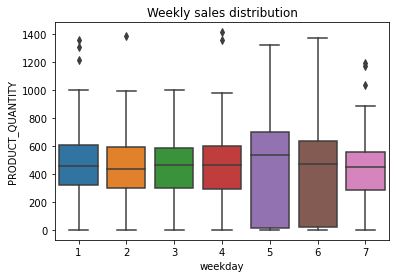

In [49]:
## plotting weekday wise

plot = sn.boxplot(x='weekday', y='PRODUCT_QUANTITY', data=df_bv)
_ = plot.set(title='Weekly sales distribution')

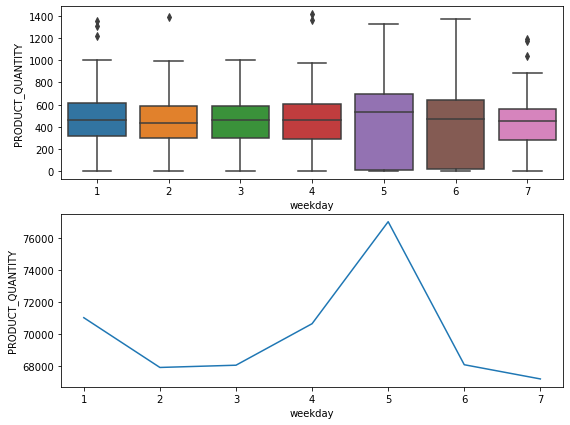

In [50]:
## plotting weekday wise

week_agg = df_bv.groupby('weekday')['PRODUCT_QUANTITY'].sum().reset_index()
fig, axs = plt.subplots(nrows=2, figsize=(9,7))
sn.boxplot(x='weekday', y='PRODUCT_QUANTITY', data=df_bv, ax=axs[0])
_ = sn.lineplot(x='weekday', y='PRODUCT_QUANTITY', data=week_agg, ax=axs[1])

Here, Monday is 7th weekday and sunday is 6th, saturday is 5th, friday is 4th, thursday is 3th, wednesday is 2nd, and tuesday is 1st day.
So, here we can see there is an increment in sale from 4th day  i.e friday to 5th day i.e. saturday(it is having highest count of PRODUCT_QUANTITY of BurgerVeggie), there is a sudden fall for sundays.

Here we can see that for 2nd, 3rd, 4th and 7th day, we have almost same rate of sale.

###### --> month-wise plotting of data

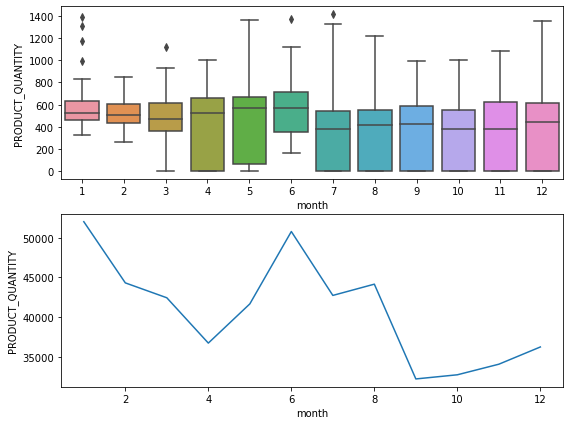

In [51]:
## plotting month wise

monthly_agg = df_bv.groupby('month')['PRODUCT_QUANTITY'].sum().reset_index()
fig, axs = plt.subplots(nrows=2, figsize=(9,7))
sn.boxplot(x='month', y='PRODUCT_QUANTITY', data=df_bv, ax=axs[0])
_ = sn.lineplot(x='month', y='PRODUCT_QUANTITY', data=monthly_agg, ax=axs[1])

Here, we can see that we have peak for 6th month(June) having highest sale of Burger Veggie, probably because thats when vacations are on and people go for junk foods in get-togethers and snacks. 
There is a fall in the month of April and a sudden fall in the month of september.
There is a steady fall from January to April and then a sudden increment for mont of May followed by June.

###### --> Year-wise plotting of data

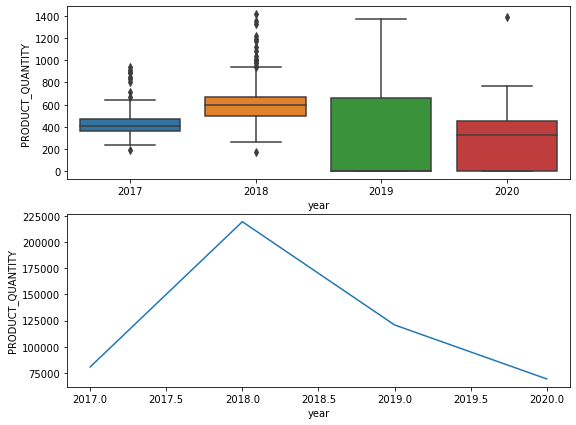

In [52]:
## plotting year wise data
yearly_agg = df_bv.groupby('year')['PRODUCT_QUANTITY'].sum().reset_index()
fig, axs = plt.subplots(nrows=2, figsize=(9,7))
sn.boxplot(x='year', y='PRODUCT_QUANTITY', data=df_bv, ax=axs[0])
_ = sn.lineplot(x='year', y='PRODUCT_QUANTITY', data=yearly_agg, ax=axs[1])

Here we can see that there is constant increment in sale from 2017 to having peak in 2018, and then there is a smooth fall in sale.
There is the minimum sale in 2020, that's when lockdown hit and people avoid outside food. 

###### --> Day-wise plotting of data

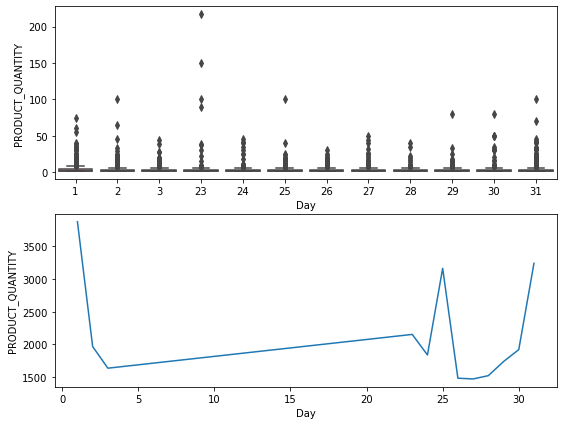

In [52]:
## plotting day wise

day_agg = temp_df_bv.groupby('Day')['PRODUCT_QUANTITY'].sum().reset_index()
fig, axs = plt.subplots(nrows=2, figsize=(9,7))
sn.boxplot(x='Day', y='PRODUCT_QUANTITY', data=temp_df_bv, ax=axs[0])
_ = sn.lineplot(x='Day', y='PRODUCT_QUANTITY', data=day_agg, ax=axs[1])

 Here we can see that there's so many ups and down in the graph, but still across the mid of the month, we are having some peaks, and there's the highest peak for the first day of the month.
So we can say that there's an increment in sale during the first half of the month(time of salary being credited). 

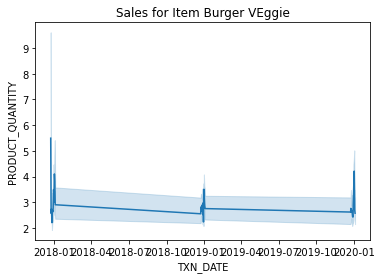

In [53]:
## plotting date wise data with years
plot = sn.lineplot(x='TXN_DATE', y='PRODUCT_QUANTITY', data=temp_df_bv)
_ = plot.set(title='Sales for Item Burger VEggie')


 Here we can see that there's a gap in sale from last of 2019 to early start of 2020. There's serious ups and downs in 2020 that is due to lockdown.

### Quick Check for Autocorrelation

There is a quick, visual check that we can do to see if there is an autocorrelation in our time series dataset.

We can plot the observation at the previous time step (t-1) with the observation at the next time step (t+1) as a scatter plot.

This could be done manually by first creating a lag version of the time series dataset and using a built-in scatter plot function in the Pandas library.

But there is an easier way.

Pandas provides a built-in plot to do exactly this, called the lag_plot() function.

Below is an example of creating a lag plot of the Sale of Burger Veggie dataset.

Running the code to  plot the sale data (t) on the x-axis against the sale on the previous day (t-1) on the y-axis.

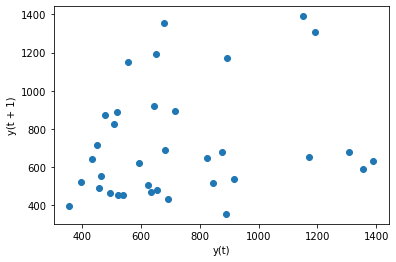

In [54]:
from pandas.plotting import lag_plot
from matplotlib import pyplot
lag_plot(temp_bv)
pyplot.show()

We can see a MOST balls of observations along a diagonal line of the plot. It clearly shows a relationship or some correlation.

This process could be repeated for any other lagged observation, such as if we wanted to review the relationship with the last 7 days or with the same day last month or last year.

Another quick check that we can do is to directly calculate the correlation between the observation and the lag variable.

We can use a statistical test like the Pearson correlation coefficient. This produces a number to summarize how correlated two variables are between -1 (negatively correlated) and +1 (positively correlated) with small values close to zero indicating low correlation and high values above 0.5 or below -0.5 showing high correlation.

Correlation can be calculated easily using the corr() function on the DataFrame of the lagged dataset.

The example below creates a lagged version of the sale of Burger Veggie dataset and calculates a correlation matrix of each column with other columns, including itself.

In [55]:
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot

values = DataFrame(temp_bv.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

          t-1       t+1
t-1  1.000000  0.218599
t+1  0.218599  1.000000


In [ ]:
##This is a good confirmation for the plot above.

##It shows a strong positive correlation (0.82956) between the observation and the lag=1 value.

### Autocorrelation Plots

We can plot the correlation coefficient for each lag variable.

This can very quickly give an idea of which lag variables may be good candidates for use in a predictive model and how the relationship between the observation and its historic values changes over time.

We could manually calculate the correlation values for each lag variable and plot the result. Thankfully, Pandas provides a built-in plot called the autocorrelation_plot() function.

The plot provides the lag number along the x-axis and the correlation coefficient value between -1 and 1 on the y-axis. The plot also includes solid and dashed lines that indicate the 95% and 99% confidence interval for the correlation values. Correlation values above these lines are more significant than those below the line, providing a threshold or cutoff for selecting more relevant lag values.

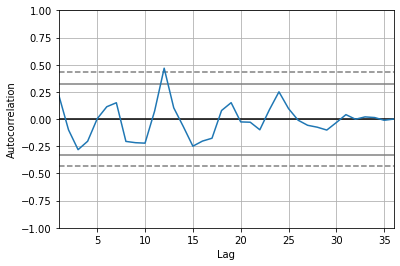

In [56]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(temp_bv)
pyplot.show()

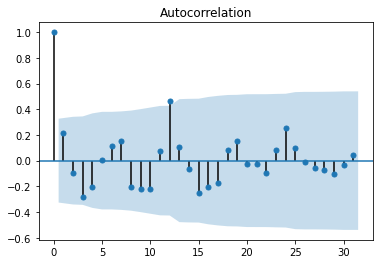

In [57]:
## using lag=31 for readability
plot_acf(temp_bv, lags=31)
pyplot.show()

Now that we know how to review the autocorrelation in our time series, let’s look at modeling it with an autoregression.

Before we do that, let’s establish a baseline performance.

## Persistence Model

Let’s say that we want to develop a model to predict the last 7 days of sale in the dataset given all prior observations.

The simplest model that we could use to make predictions would be to persist the last observation. We can call this a persistence model and it provides a baseline of performance for the problem that we can use for comparison with an autoregression model.

We can develop a test harness for the problem by splitting the observations into training and test sets, with only the last 7 observations in the dataset assigned to the test set as “unseen” data that we wish to predict.

The predictions are made using a walk-forward validation model so that we can persist the most recent observations for the next day. This means that we are not making a 7-day forecast, but 7 1-day forecasts.

Test MSE: 59153.429


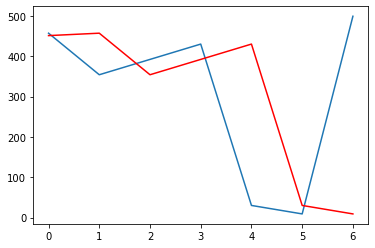

In [77]:
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error

# create lagged dataset
values = DataFrame(temp_bv.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']

# split into train and test sets
X = dataframe.values
train, test = X[1:len(X)-7], X[len(X)-7:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]
 
# persistence model
def model_persistence(x):
    return x
 
# walk-forward validation
predictions = list()
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)
# plot predictions vs expected
pyplot.plot(test_y)
pyplot.plot(predictions, color='red')
pyplot.show()

 ###### there is a big difference between the predicted and actual value for 7th day which results in high MSE value.

## Autoregression Model

An autoregression model is a linear regression model that uses lagged variables as input variables.

We could calculate the linear regression model manually using the LinearRegession class in scikit-learn and manually specify the lag input variables to use.

Alternately, the statsmodels library provides an autoregression model where you must specify an appropriate lag value and trains a linear regression model. It is provided in the AutoReg class.

We can use this model by first creating the model AutoReg() and then calling fit() to train it on our dataset. This returns an AutoRegResults object.

Once fit, we can use the model to make a prediction by calling the predict() function for a number of observations in the future. This creates 1 7-day forecast, which is different from the persistence example above.

Coefficients: [ 1.40866957e+01  3.97240946e-01  6.86202755e-02  1.62741995e-01
  1.51330295e-02  4.42681704e-02  9.43708105e-02  1.81224222e-01
 -3.25917535e-02 -2.49682543e-02 -2.86001160e-02  5.93096153e-03
 -4.57219875e-03 -9.85421503e-03  1.36997114e-01 -7.68066983e-02
  2.71216096e-02  4.97204079e-03  4.37225388e-02 -2.86914985e-02
 -3.04641321e-02  2.27798398e-02 -1.48789564e-02 -1.90007470e-02
  1.67041590e-02 -3.87181265e-02 -3.43952699e-02  3.17289519e-02
  5.66585502e-02 -1.40543597e-03]
predicted=324.481139, expected=457.000000
predicted=292.634539, expected=354.000000
predicted=378.184723, expected=392.000000
predicted=358.331675, expected=430.000000
predicted=179.702604, expected=30.000000
predicted=211.204106, expected=9.000000
predicted=377.513444, expected=499.000000
Test RMSE: 122.306


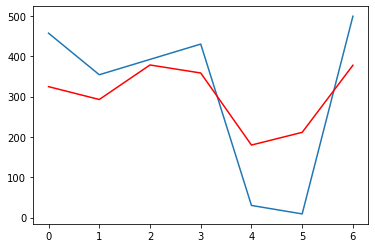

In [78]:
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt


# split dataset
X = temp_bv.values
train, test = X[1:len(X)-7], X[len(X)-7:]
# train autoregression
model = AutoReg(train, lags=29)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions[i], test[i]))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot results
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

###### there is a big differnce between the predicted and actual value for 5th and 6th day

The statsmodels API does not make it easy to update the model as new observations become available.

One way would be to re-train the AutoReg model each day as new observations become available, and that may be a valid approach, if not computationally expensive.

An alternative would be to use the learned coefficients and manually make predictions. This requires that the history of 29 prior observations be kept and that the coefficients be retrieved from the model and used in the regression equation to come up with new forecasts.

The coefficients are provided in an array with the intercept term followed by the coefficients for each lag variable starting at t-1 to t-n. We simply need to use them in the right order on the history of observations, as follows:

yhat = b0 + b1*X1 + b2*X2 ... bn*Xn


predicted=324.481139, expected=457.000000
predicted=345.276457, expected=354.000000
predicted=411.655078, expected=392.000000
predicted=389.596967, expected=430.000000
predicted=221.112355, expected=30.000000
predicted=165.697341, expected=9.000000
predicted=314.012022, expected=499.000000
Test RMSE: 128.149


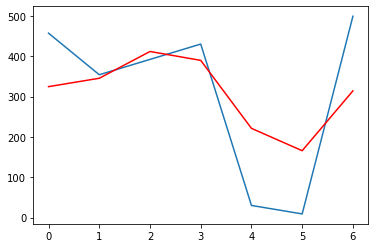

In [79]:
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt

# split dataset
X = temp_bv.values
train, test = X[1:len(X)-7], X[len(X)-7:]
# train autoregression
window = 29
model = AutoReg(train, lags=29)
model_fit = model.fit()
coef = model_fit.params
# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test)):
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    yhat = coef[0]
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [ ]:
##here we can see a big difference for day 4 and 5 between predicted and actual values.

## Quantitative Methods to Forecast Product Sales

It can be fairly concluded from the data exploratory plots above that there is seasonality present in the product sales data, along with a general increase in the number of sales over the years. Therefore, in order to forecast the number of sales for the last three months of 2020, we will keep in mind the linear trend and seasonality present in the product sales.
There are multiple ways to approach the forecasting problem, we can either build traditional time series models, or use causal models, such as linear regression. We will look at both these methods and try to evaluate our forecasts using the validation set.


### Time Series Decomposition Plot

A time series decomposition plot allows us to observe the seasonality, trend, and error/remainder terms of a time series. 

Time Series Components

A useful abstraction for selecting forecasting methods is to break a time series down into systematic and unsystematic components.

   Systematic: Components of the time series that have consistency or recurrence and can be described and modeled.
    Non-Systematic: Components of the time series that cannot be directly modeled.

A given time series is thought to consist of three systematic components including level, trend, seasonality, and one non-systematic component called noise.

These components are defined as follows:

   Level: The average value in the series.
    Trend: The increasing or decreasing value in the series.
    Seasonality: The repeating short-term cycle in the series.
    Noise: The random variation in the series.






In [56]:
ts_decomp_df = train_df_bv.set_index('TXN_DATE') # set date as index
ts_decomp_df['PRODUCT_QUANTITY'] = ts_decomp_df['PRODUCT_QUANTITY'].astype(float)
ts_decomp_df.head()
print(ts_decomp_df.shape)

(1066, 5)


#### Combining Time Series Components

A series is thought to be an aggregate or combination of these four components.

All series have a level and noise. The trend and seasonality components are optional.

It is helpful to think of the components as combining either additively or multiplicatively.

##### -Additive Model

An additive model suggests that the components are added together as follows:
y(t) = Level + Trend + Seasonality + Noise


An additive model is linear where changes over time are consistently made by the same amount.

A linear trend is a straight line.

A linear seasonality has the same frequency (width of cycles) and amplitude (height of cycles).

##### -Multiplicative Model

A multiplicative model suggests that the components are multiplied together as follows:

y(t) = Level * Trend * Seasonality * Noise

A multiplicative model is nonlinear, such as quadratic or exponential. Changes increase or decrease over time.

A nonlinear trend is a curved line.

A non-linear seasonality has an increasing or decreasing frequency and/or amplitude over time.

##### The Trend component

The Trend component refers to the pattern in the data that spans across seasonal periods.

##### The Seasonal component

The seasonal component explains the periodic ups and downs one sees in many data sets

##### The Noise component

The noise or the random component is what remains behind when you separate out seasonality and trend from the time series. Noise is the effect of factors that you do not know, or which you cannot measure. It is the effect of the known unknowns, or the unknown unknowns.

<Figure size 432x288 with 0 Axes>

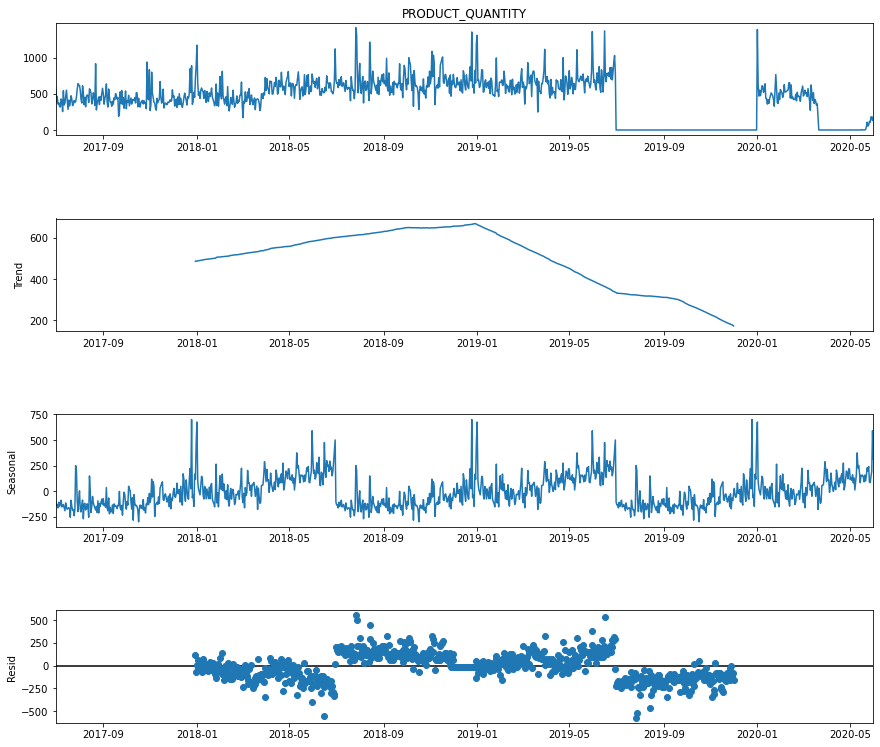

In [57]:
result = seasonal_decompose(ts_decomp_df['PRODUCT_QUANTITY'], model='additive', freq=365)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(14, 12)

 here, frequancy is 365 days
-- we can see that there is a seasonality in the first month of the year in every year
-- there is a small fall in sale around mid of the year else,there are same patterns across the year in seasonality
-- There is a linear trend line


<Figure size 432x288 with 0 Axes>

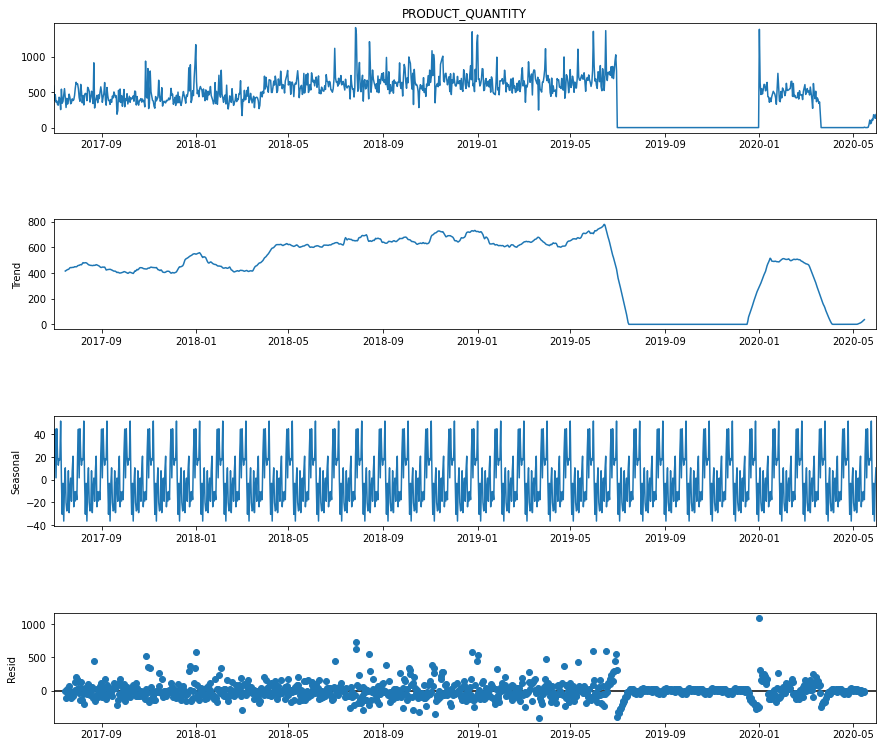

In [58]:
result = seasonal_decompose(ts_decomp_df['PRODUCT_QUANTITY'], model='additive', freq=30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(14, 12)

# ARIMA MODEL

### ACF
ACF is an (complete) auto-correlation function which gives us values of auto-correlation of any series with its lagged values. We plot these values along with the confidence band.
We have an ACF plot. In simple terms, it describes how well the present value of the series is related with its past values. A time series can have components like trend, seasonality, cyclic and residual. ACF considers all these components while finding correlations hence it’s a ‘complete auto-correlation plot’.

### PACF 
PACF is a partial auto-correlation function. Basically instead of finding correlations of present with lags like ACF, it finds correlation of the residuals (which remains after removing the effects which are already explained by the earlier lag(s)) with the next lag value hence ‘partial’ and not ‘complete’ as we remove already found variations before we find the next correlation.
So if there is any hidden information in the residual which can be modeled by the next lag, we might get a good correlation and we will keep that next lag as a feature while modeling. Remember while modeling we don’t want to keep too many features which are correlated as that can create multicollinearity issues. Hence we need to retain only the relevant features.

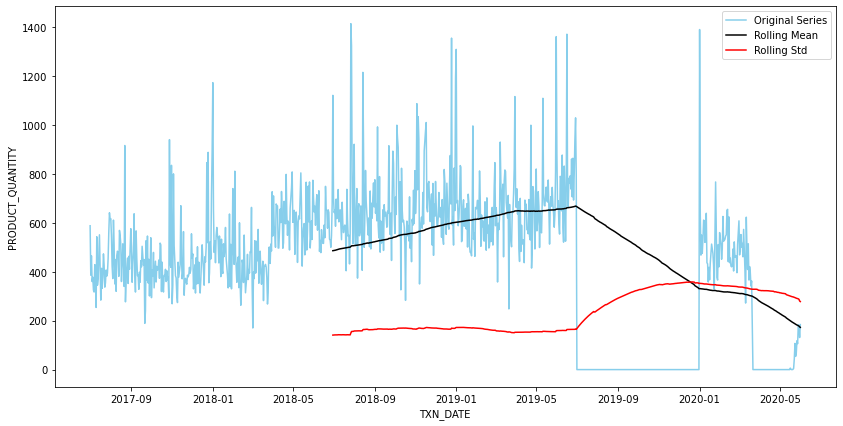

Test statistic = -2.179
P-value = 0.214
Critical values :
	1%: -3.4365872439265366 - The data is not stationary with 99% confidence
	5%: -2.8642939151214337 - The data is not stationary with 95% confidence
	10%: -2.568236291810346 - The data is not stationary with 90% confidence


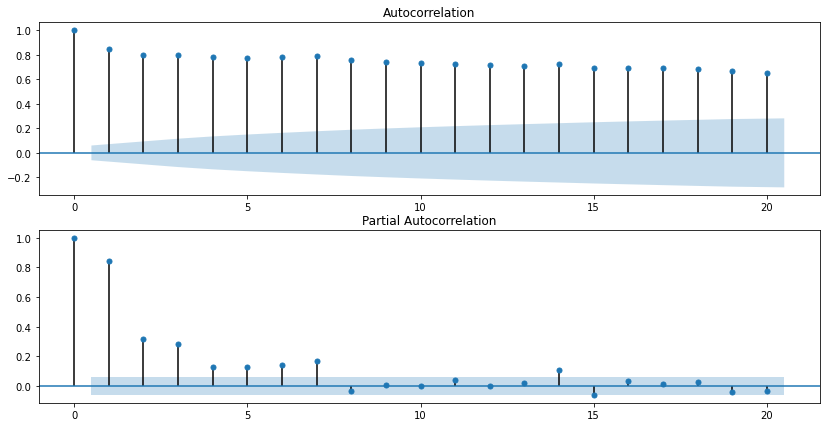

In [60]:
arima_df_bv = train_df_bv[['TXN_DATE', 'PRODUCT_QUANTITY']].set_index('TXN_DATE')
arima_test_df_bv = test_df_bv[['TXN_DATE', 'PRODUCT_QUANTITY']].set_index('TXN_DATE')

def test_stationarity(timeseries):
    # Plotting rolling statistics
    rollmean = timeseries.rolling(window=365).mean()
    rollstd = timeseries.rolling(window=365).std()

    plt.figure(figsize=(14,7))
    plt.plot(timeseries, color='skyblue', label='Original Series')
    plt.plot(rollmean, color='black', label='Rolling Mean')
    plt.plot(rollstd, color='red', label='Rolling Std')
    plt.legend(loc='best')
    plt.xlabel('TXN_DATE')
    plt.ylabel('PRODUCT_QUANTITY')
    plt.show()
    
    # Augmented Dickey-Fuller Test
    adfuller_test = adfuller(timeseries, autolag='AIC')
    print("Test statistic = {:.3f}".format(adfuller_test[0]))
    print("P-value = {:.3f}".format(adfuller_test[1]))
    print("Critical values :")
    
    for key, value in adfuller_test[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence"
              .format(key, value, '' if adfuller_test[0] < value else 'not', 100-int(key[:-1])))
        
    # Autocorrelation Plots
    fig, ax = plt.subplots(2, figsize=(14,7))
    ax[0] = plot_acf(timeseries, ax=ax[0], lags=20)
    ax[1] = plot_pacf(timeseries, ax=ax[1], lags=20)
    
test_stationarity(arima_df.PRODUCT_QUANTITY)

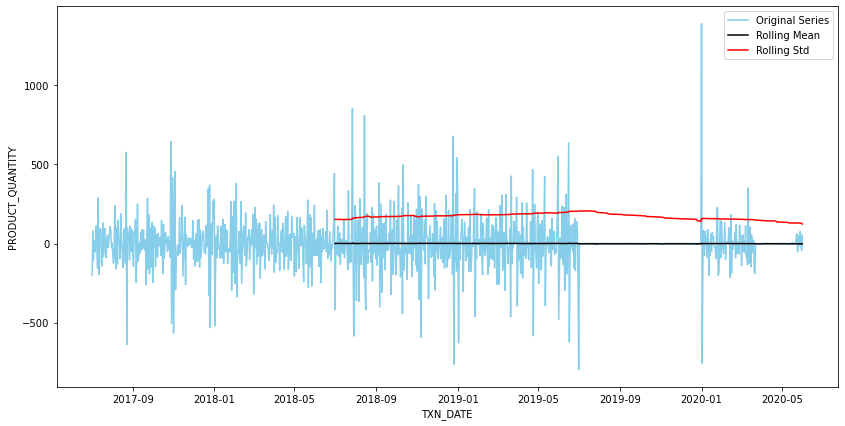

Test statistic = -11.070
P-value = 0.000
Critical values :
	1%: -3.4365931987759417 - The data is  stationary with 99% confidence
	5%: -2.864296541617536 - The data is  stationary with 95% confidence
	10%: -2.568237690702948 - The data is  stationary with 90% confidence


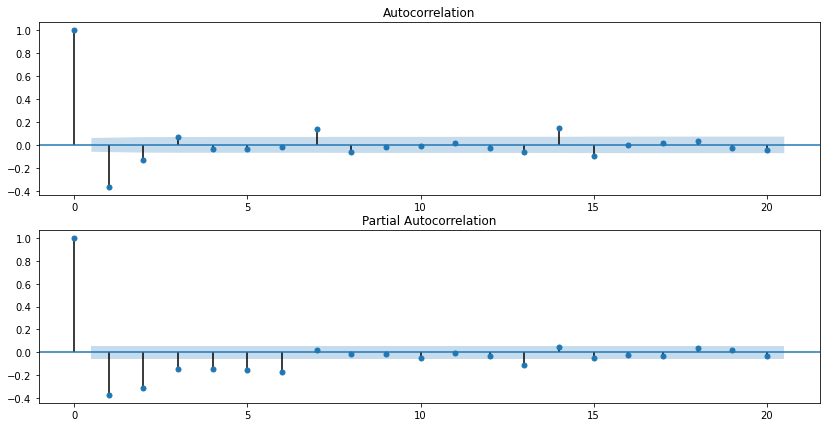

In [61]:
first_difference = arima_df_bv.PRODUCT_QUANTITY - arima_df_bv.PRODUCT_QUANTITY.shift(1)
first_difference = pd.DataFrame(first_difference.dropna(inplace=False))
# Check for stationarity after differencing
test_stationarity(first_difference.PRODUCT_QUANTITY)

In [62]:
arima_model61 = ARIMA(arima_df_bv.PRODUCT_QUANTITY, (3,1,1)).fit(disp=False)
print(arima_model61.summary())

C:\Users\pc\.conda\envs\tensorflow_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\pc\.conda\envs\tensorflow_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:     D.PRODUCT_QUANTITY   No. Observations:                 1065
Model:                 ARIMA(3, 1, 1)   Log Likelihood               -6743.298
Method:                       css-mle   S.D. of innovations            135.972
Date:                Thu, 03 Dec 2020   AIC                          13498.596
Time:                        12:11:01   BIC                          13528.420
Sample:                    07-02-2017   HQIC                         13509.897
                         - 05-31-2020                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.2953      1.022     -0.289      0.772      -2.298       1.707
ar.L1.D.PRODUCT_QUANTITY     0.2120      0.051      4.137      0.000       0.112       0.

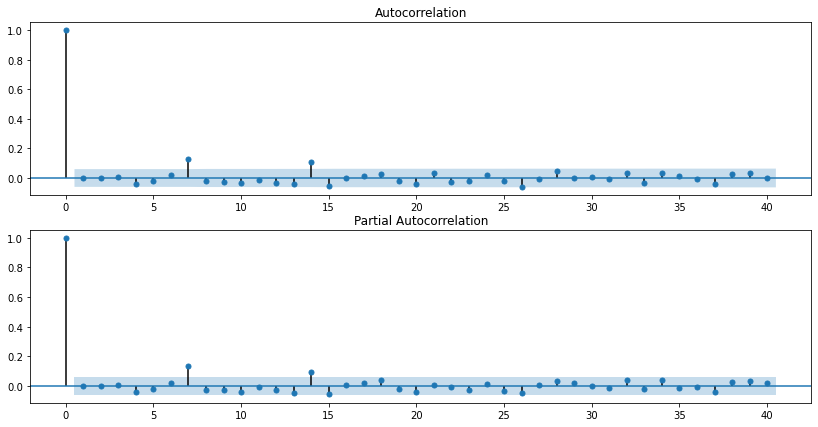

In [63]:
residuals = arima_model61.resid
# Checking for seasonality
fig, ax = plt.subplots(2, figsize=(14,7))
ax[0] = plot_acf(residuals, ax=ax[0], lags=40)
ax[1] = plot_pacf(residuals, ax=ax[1], lags=40)

## ## Supervised Machine Learning: Linear Regression

#Let's apply Linear Regression to our time series data in order to forecasts sales.


In [85]:


reg_df = df_bv
reg_df



,TXN_DATE,PRODUCT_QUANTITY
0,2017-07-01,588.0
1,2017-07-02,386.0
2,2017-07-03,465.0
3,2017-07-04,360.0
4,2017-07-05,378.0
...,...,...
1153,2020-08-27,392.0
1154,2020-08-28,430.0
1155,2020-08-29,30.0
1156,2020-08-30,9.0


In [86]:
# Create Date-related Features to be used for EDA 
reg_df['year'] = reg_df['TXN_DATE'].dt.year
reg_df['month'] = reg_df['TXN_DATE'].dt.month
reg_df['day'] = reg_df['TXN_DATE'].dt.day
reg_df['weekday'] = reg_df['TXN_DATE'].dt.weekday
reg_df['weekday'] = np.where(reg_df.weekday == 0, 7, reg_df.weekday)

reg_df

,TXN_DATE,PRODUCT_QUANTITY,year,month,day,weekday
0,2017-07-01,588.0,2017,7,1,5
1,2017-07-02,386.0,2017,7,2,6
2,2017-07-03,465.0,2017,7,3,7
3,2017-07-04,360.0,2017,7,4,1
4,2017-07-05,378.0,2017,7,5,2
...,...,...,...,...,...,...
1153,2020-08-27,392.0,2020,8,27,3
1154,2020-08-28,430.0,2020,8,28,4
1155,2020-08-29,30.0,2020,8,29,5
1156,2020-08-30,9.0,2020,8,30,6


In [87]:

##Step 1: Feature Engineering

# Lag features
for i in range(1,8):
    lag_i = 'lag_' + str(i)
    reg_df[lag_i] = reg_df.PRODUCT_QUANTITY.shift(i)
    
# Rolling window
reg_df['rolling_mean'] = reg_df.PRODUCT_QUANTITY.rolling(window=7).mean()
reg_df['rolling_max'] = reg_df.PRODUCT_QUANTITY.rolling(window=7).max()
reg_df['rolling_min'] = reg_df.PRODUCT_QUANTITY.rolling(window=7).min()

reg_df = reg_df.dropna(how='any', inplace=False)
#reg_df = reg_df.drop(['PRODUCT_NAME'], axis=1)

# Split the series to predict the last 3 months of 2020
reg_df = reg_df.set_index('TXN_DATE')
reg_train_df = reg_df.loc[:'2020-05-31']                        
reg_test_df = reg_df.loc['2020-06-01':]



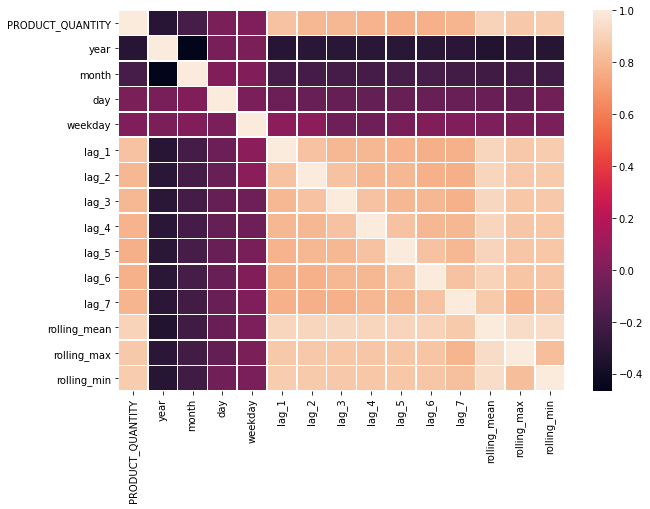

In [88]:

##Step 2: Feature Selection and Model BuildinG

# Correlation matrix with heatmap
corr = reg_train_df.corr()
fig = plt.figure(figsize=(10,7))
_ = sn.heatmap(corr, linewidths=.5)



In [89]:
X_train = reg_train_df.drop(['PRODUCT_QUANTITY'], axis=1)
y_train = reg_train_df['PRODUCT_QUANTITY'].values

X_test = reg_test_df.drop(['PRODUCT_QUANTITY'], axis=1)
y_test = reg_test_df['PRODUCT_QUANTITY'].values

#Univariate SelectKBest class to extract top 5 best features
top_features = SelectKBest(score_func=f_regression, k=5)
fit = top_features.fit(X_train, y_train)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X_train.columns)

#concat two dataframes for better visualization 
feature_scores = pd.concat([df_columns, df_scores], axis=1)
feature_scores.columns = ['Feature','Score']  # naming the dataframe columns
print(feature_scores.nlargest(5,'Score'))  # print 5 best features

         Feature        Score
11  rolling_mean  4766.477101
13   rolling_min  3562.037668
12   rolling_max  3120.568603
4          lag_1  2596.226512
6          lag_3  1917.321200


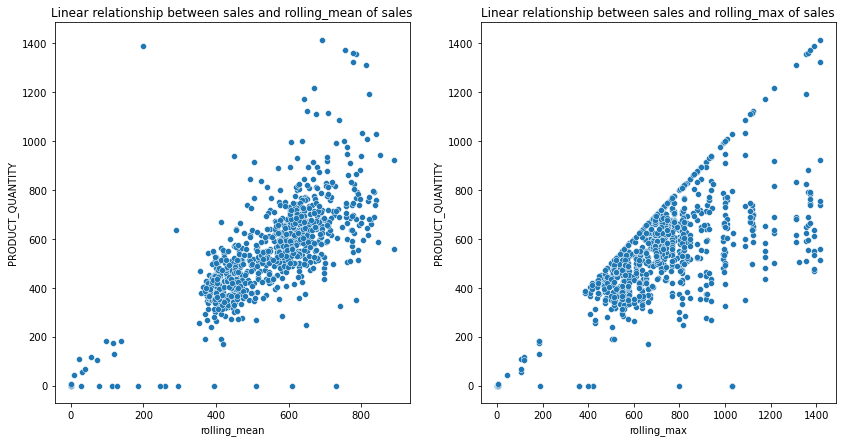

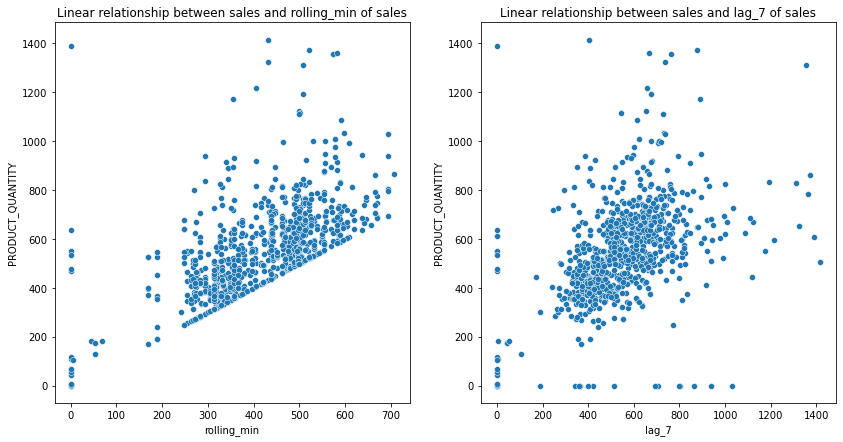

In [90]:
# Checking for a linear relationship of the top features with sales (target variable)
fig, axs = plt.subplots(ncols=2, figsize=(14,7))
sn.scatterplot(reg_train_df.rolling_mean, reg_train_df.PRODUCT_QUANTITY, ax=axs[0])
axs[0].set(title='Linear relationship between sales and rolling_mean of sales')
sn.scatterplot(reg_train_df.rolling_max, reg_train_df.PRODUCT_QUANTITY, ax=axs[1])
axs[1].set(title='Linear relationship between sales and rolling_max of sales')

fig, axs = plt.subplots(ncols=2, figsize=(14,7))
sn.scatterplot(reg_train_df.rolling_min, reg_train_df.PRODUCT_QUANTITY, ax=axs[0])
axs[0].set(title='Linear relationship between sales and rolling_min of sales')
sn.scatterplot(reg_train_df.lag_7, reg_train_df.PRODUCT_QUANTITY, ax=axs[1])
_ = axs[1].set(title='Linear relationship between sales and lag_7 of sales')

In [91]:
# update X_train, X_test to include top features
X_train = X_train[['rolling_mean', 'rolling_max', 'rolling_min', 'lag_7', 'lag_1']]
X_test = X_test[['rolling_mean', 'rolling_max', 'rolling_min', 'lag_7', 'lag_1']]

# fit model
model = LinearRegression()
model.fit(X_train, y_train)

preds = model.predict(X_test)

errors_df = reg_test_df[['PRODUCT_QUANTITY']]
errors_df['pred_sales'] = preds
errors_df['errors'] = preds - y_test
#print(error_df)
errors_df.insert(0, 'model', 'LinearRegression')

In [92]:
errors_df

,model,PRODUCT_QUANTITY,pred_sales,errors
TXN_DATE,,,,
2020-06-01,LinearRegression,244.0,161.121385,-82.878615
2020-06-02,LinearRegression,322.0,190.975801,-131.024199
2020-06-03,LinearRegression,166.0,211.021465,45.021465
2020-06-04,LinearRegression,353.0,213.991739,-139.008261
2020-06-05,LinearRegression,315.0,228.417327,-86.582673
...,...,...,...,...
2020-08-27,LinearRegression,392.0,199.793616,-192.206384
2020-08-28,LinearRegression,430.0,200.077337,-229.922663
2020-08-29,LinearRegression,30.0,184.579107,154.579107


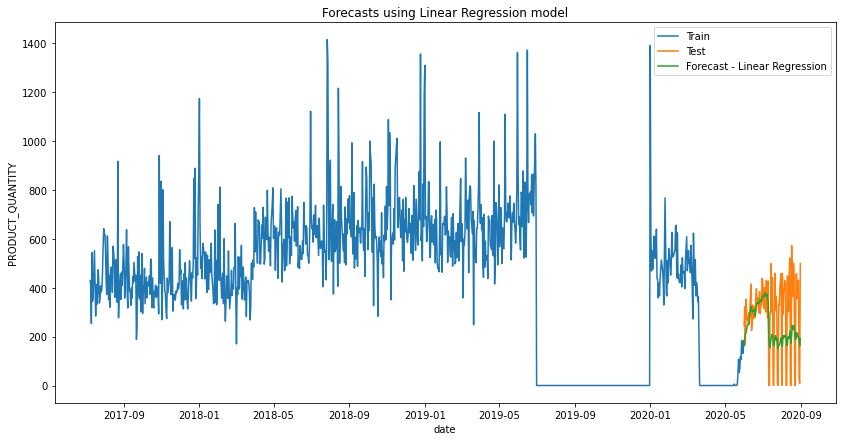

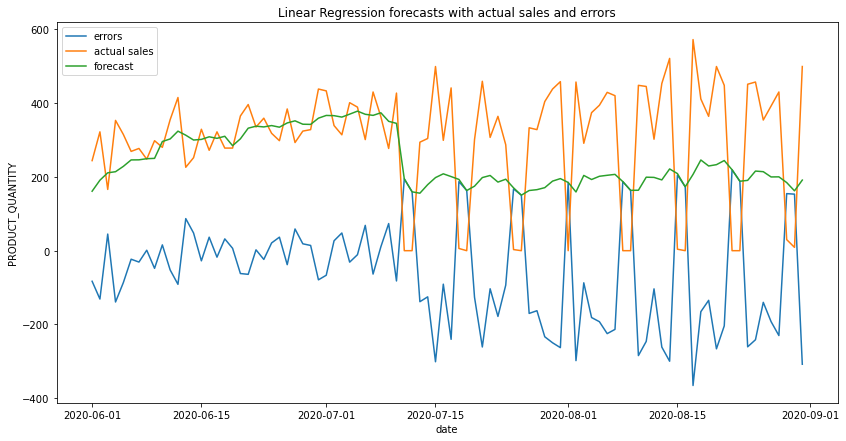

NameError: name 'mae' is not defined

In [93]:

##Step 3: Model Evaluation and Predictions


# eval predictions
fig = plt.figure(figsize=(14,7))
plt.plot(reg_train_df.index, reg_train_df['PRODUCT_QUANTITY'], label='Train')
plt.plot(reg_test_df.index, reg_test_df['PRODUCT_QUANTITY'], label='Test')
plt.plot(errors_df.index, errors_df['pred_sales'], label='Forecast - Linear Regression')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('PRODUCT_QUANTITY')
plt.title('Forecasts using Linear Regression model')
plt.show()

fig = plt.figure(figsize=(14,7))
plt.plot(errors_df.index, errors_df.errors, label='errors')
plt.plot(errors_df.index, errors_df.PRODUCT_QUANTITY, label='actual sales')
plt.plot(errors_df.index, errors_df.pred_sales, label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('PRODUCT_QUANTITY')
plt.title('Linear Regression forecasts with actual sales and errors')
plt.show()

result_df_lr = errors_df.groupby('model').agg(total_sales=('PRODUCT_QUANTITY', 'sum'),
                                          total_pred_sales=('pred_sales', 'sum'),
                                          LR_overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse), 
                                          MAPE=('errors', mape))
result_df_lr



## simple Arima model 

In [93]:
temp = df.groupby('TXN_DATE').PRODUCT_QUANTITY.sum() #.astype('float')
temp

TXN_DATE
2017-07-01    588.0
2017-07-02    386.0
2017-07-03    465.0
2017-07-04    360.0
2017-07-05    378.0
              ...  
2020-08-27    362.0
2020-08-28    416.0
2020-08-29     30.0
2020-08-30      9.0
2020-08-31    472.0
Name: PRODUCT_QUANTITY, Length: 1158, dtype: float64

In [94]:
# Fill in missing values (some dates are missing in the index)
start_date = temp.index[0].date()
end_date = temp.index[-1].date()
date_range = pd.date_range(start_date, end_date)
X = temp.reindex(date_range, fill_value=0).values
X.shape

(1158,)

In [95]:
# Divide into train and test
train = X[:900]
test = X[900:]
train.size, test.size

(900, 258)

In [96]:
# Forecast using ARIMA
from statsmodels.tsa.arima_model import ARIMA

history = list(train)
predicted = []
for i in range(len(test)):
    if (i+1) % 10 == 0:
        print("Forecasting #{}".format(i+1))
    predicted.append(ARIMA(history, order=(5,1,0)).fit().forecast()[0])
    history.append(test[i])

Forecasting #10
Forecasting #20
Forecasting #30
Forecasting #40
Forecasting #50
Forecasting #60
Forecasting #70
Forecasting #80
Forecasting #90
Forecasting #100
Forecasting #110
Forecasting #120
Forecasting #130
Forecasting #140
Forecasting #150
Forecasting #160
Forecasting #170
Forecasting #180
Forecasting #190
Forecasting #200
Forecasting #210
Forecasting #220
Forecasting #230
Forecasting #240
Forecasting #250


In [130]:
predicted

[array([-1.45340638]),
 array([-1.45206904]),
 array([-1.45012295]),
 array([-1.44858619]),
 array([-1.4470842]),
 array([-1.44492401]),
 array([-1.44339621]),
 array([-1.44238503]),
 array([-1.44049815]),
 array([-1.43907316]),
 array([-1.43742451]),
 array([-1.43590865]),
 array([-1.43413149]),
 array([-1.43260358]),
 array([-1.43107522]),
 array([439.77468353]),
 array([372.67758985]),
 array([425.31942001]),
 array([399.17000247]),
 array([404.18348934]),
 array([571.87038563]),
 array([469.89389315]),
 array([467.92917593]),
 array([444.72518512]),
 array([430.38084403]),
 array([487.07592488]),
 array([415.7872719]),
 array([423.05075025]),
 array([342.10651142]),
 array([358.81311344]),
 array([352.68811206]),
 array([344.69301367]),
 array([352.46558229]),
 array([365.68456018]),
 array([399.18488958]),
 array([385.90018682]),
 array([368.0931688]),
 array([340.91825273]),
 array([359.28331643]),
 array([464.60262404]),
 array([439.4035049]),
 array([395.13590877]),
 array([369

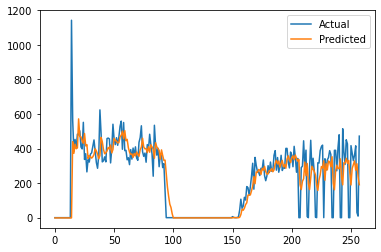

In [97]:
# Let's see the predictions compared to actual values
plt.plot(test, label='Actual')
plt.plot(predicted, label='Predicted')
plt.legend()

In [98]:
# Calculate errors
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test, predicted)
print("MSE = {:.4f}".format(mse))

MSE = 15241.3454


# After all the evaluations and trial of methods
# Final Implementation with predictions

Taking data in week wise, month wise and day wise for evaluation

In [94]:
new_df = data[['TXN_DATE', 'PRODUCT_QUANTITY','PRODUCT_NAME']]

new_df

,TXN_DATE,PRODUCT_QUANTITY,PRODUCT_NAME
2502567,2017-07-01,0.25,(MB) COOKIES MILK PISTA
2144199,2017-07-01,0.10,(MB) COOKIES JEERA BUTTER
2144200,2017-07-01,0.25,(MB) COOKIES NO ADDED SUGAR ALMOND
2144201,2017-07-01,1.00,(MB) CUSTARD FRUIT (E/L)
2144202,2017-07-01,1.00,(MB) DOUGHNUT CHOCOLATE
...,...,...,...
1371710,2020-08-31,1.00,(MB) COOKIES JEERA BUTTER
1371709,2020-08-31,1.00,(MB) BREAD MULTIGRAIN
1371708,2020-08-31,4.00,(MB) PATTY AALOO VEG
1371717,2020-08-31,2.00,(MB) COOKIES COCONUT SQUARE


In [95]:
## taking only Burger Veggie(as a product) into account

new_df = new_df[new_df['PRODUCT_NAME'] == '(MB) BURGER VEGGIE']

new_df

,TXN_DATE,PRODUCT_QUANTITY,PRODUCT_NAME
2144096,2017-07-01,105.0,(MB) BURGER VEGGIE
2144150,2017-07-01,4.0,(MB) BURGER VEGGIE
2144108,2017-07-01,3.0,(MB) BURGER VEGGIE
2144112,2017-07-01,2.0,(MB) BURGER VEGGIE
2144114,2017-07-01,1.0,(MB) BURGER VEGGIE
...,...,...,...
1371630,2020-08-31,1.0,(MB) BURGER VEGGIE
1371624,2020-08-31,3.0,(MB) BURGER VEGGIE
1371622,2020-08-31,1.0,(MB) BURGER VEGGIE
1371746,2020-08-31,2.0,(MB) BURGER VEGGIE


In [96]:
temp = new_df
temp

,TXN_DATE,PRODUCT_QUANTITY,PRODUCT_NAME
2144096,2017-07-01,105.0,(MB) BURGER VEGGIE
2144150,2017-07-01,4.0,(MB) BURGER VEGGIE
2144108,2017-07-01,3.0,(MB) BURGER VEGGIE
2144112,2017-07-01,2.0,(MB) BURGER VEGGIE
2144114,2017-07-01,1.0,(MB) BURGER VEGGIE
...,...,...,...
1371630,2020-08-31,1.0,(MB) BURGER VEGGIE
1371624,2020-08-31,3.0,(MB) BURGER VEGGIE
1371622,2020-08-31,1.0,(MB) BURGER VEGGIE
1371746,2020-08-31,2.0,(MB) BURGER VEGGIE


In [97]:
temp['TXN_DATE'] = pd.to_datetime(temp['TXN_DATE'], format='%Y-%m-%d')
temp=(temp.groupby([pd.Grouper(key='TXN_DATE', freq='D')])['PRODUCT_QUANTITY'].sum()).reset_index(drop=False)
temp

,TXN_DATE,PRODUCT_QUANTITY
0,2017-07-01,588.0
1,2017-07-02,386.0
2,2017-07-03,465.0
3,2017-07-04,360.0
4,2017-07-05,378.0
...,...,...
1153,2020-08-27,392.0
1154,2020-08-28,430.0
1155,2020-08-29,30.0
1156,2020-08-30,9.0


In [98]:
# Grouping data based on month and cummulative product_quantity 

month_data = new_df.groupby([pd.Grouper(key='TXN_DATE', freq='MS')]).agg({'PRODUCT_QUANTITY':'sum'})
month_data

,PRODUCT_QUANTITY
TXN_DATE,
2017-07-01,13064.0
2017-08-01,14477.0
2017-09-01,12629.0
2017-10-01,13204.0
2017-11-01,12487.0
2017-12-01,14652.0
2018-01-01,15689.0
2018-02-01,12264.0
2018-03-01,13076.0


In [99]:
# Grouping data based on month and cummulative product_quantity 

week_data = new_df.groupby([pd.Grouper(key='TXN_DATE', freq='W')]).agg({'PRODUCT_QUANTITY':'sum'})
week_data

,PRODUCT_QUANTITY
TXN_DATE,
2017-07-02,974.0
2017-07-09,2684.0
2017-07-16,2954.0
2017-07-23,2645.0
2017-07-30,3193.0
...,...
2020-08-09,1908.0
2020-08-16,2173.0
2020-08-23,2294.0


In [100]:
from matplotlib import pylab 
from pylab import *
pylab.rcParams['figure.figsize'] = (16, 6) # size for all figures

import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'



### ETS DECOMPOSITION on week data

Here we can see that we have seasonality in data i.e peak around mid of the year
here we also have trend line 

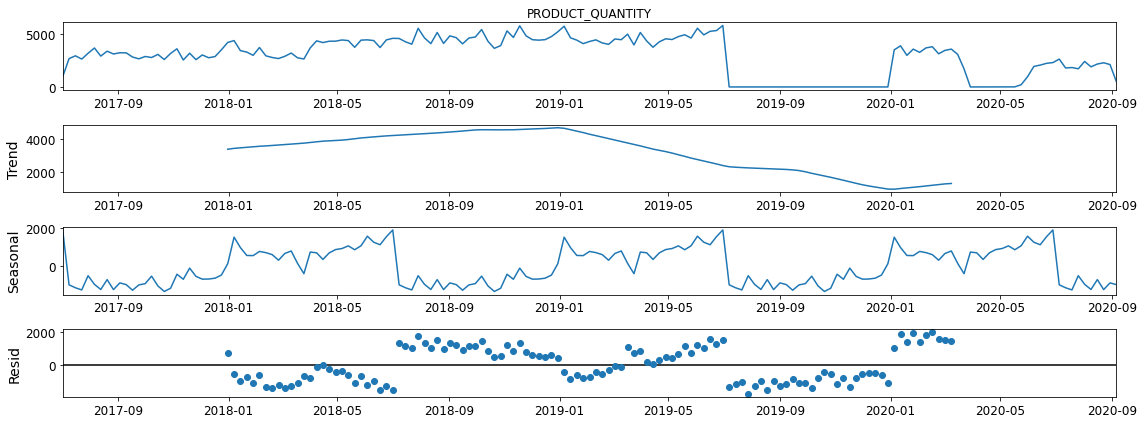

In [101]:

#ETS Decomposition

#The decomposition of a time series attempts to isolate individual components such as error, trend and seasonlaity

from statsmodels.tsa.seasonal import seasonal_decompose
ets_week = seasonal_decompose(week_data['PRODUCT_QUANTITY'],model='add') # model-> type of seasonality



ets_week.plot();



### ETS DECOMPOSITION on month data

Here we can see that we have seasonality in data i.e peak around mid of the year
here we also have trend line 

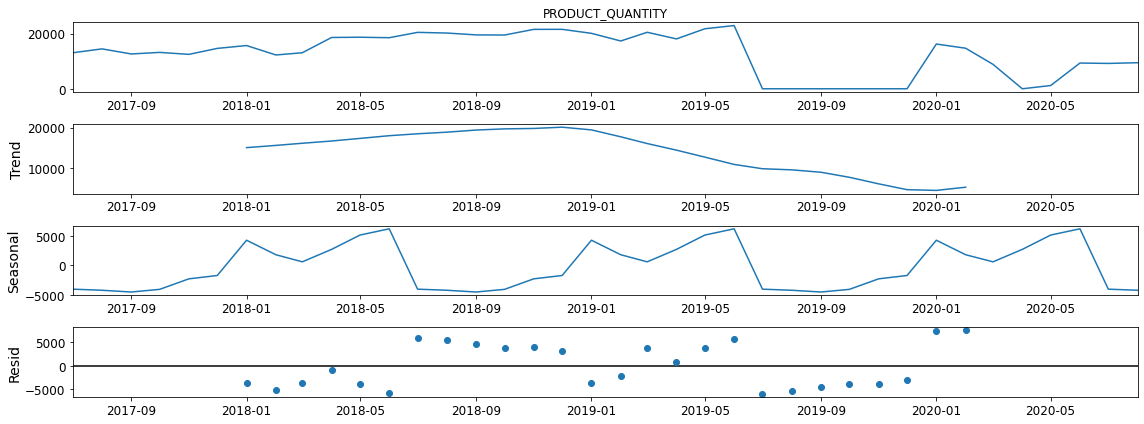

In [102]:

#ETS Decomposition

#The decomposition of a time series attempts to isolate individual components such as error, trend and seasonlaity

from statsmodels.tsa.seasonal import seasonal_decompose
ets_month = seasonal_decompose(month_data['PRODUCT_QUANTITY'],model='add') # model-> type of seasonality



ets_month.plot();



###  Forecasting Models
#### a) Holt-Winters (TES)

In [103]:
#splitting into train and test set

# Split the series to predict the last 3 months of 2020


# MONTH wise splitting

month_df = month_data#.set_index('TXN_DATE')
month_train_df = month_df.loc[:'2020-05-31']#.reset_index(drop=False)                       
month_test_df = month_df.loc['2020-06-01':]#.reset_index(drop=False)

# week wise
week_df = week_data#.set_index('TXN_DATE')
week_train_df = week_df.loc[:'2020-05-31']#.reset_index(drop=False)                       
week_test_df = week_df.loc['2020-06-01':]#.reset_index(drop=False)


In [112]:
## going with month wise data(train and test set)

from statsmodels.tsa.holtwinters import ExponentialSmoothing

fitted_model = ExponentialSmoothing(week_train_df['PRODUCT_QUANTITY'],trend='add',seasonal='add',seasonal_periods=4).fit() 



In [113]:
yhat = fitted_model.predict(len(week_train_df),len(week_train_df))

In [114]:
yhat

2020-06-07    658.39624
Freq: W-SUN, dtype: float64

In [115]:
test_predictions = fitted_model.forecast(14).rename('Holt-Winters-Forecast')

In [116]:
test_predictions

2020-06-07    658.396240
2020-06-14    597.558672
2020-06-21    788.918565
2020-06-28    808.967653
2020-07-05    625.181533
2020-07-12    564.343965
2020-07-19    755.703857
2020-07-26    775.752946
2020-08-02    591.966826
2020-08-09    531.129257
2020-08-16    722.489150
2020-08-23    742.538238
2020-08-30    558.752118
2020-09-06    497.914550
Freq: W-SUN, Name: Holt-Winters-Forecast, dtype: float64

In [117]:
compare = pd.DataFrame()

compare['Actual'] = week_test_df['PRODUCT_QUANTITY']
compare['Forecast'] = test_predictions
compare.set_index = week_test_df.index

compare

,Actual,Forecast
TXN_DATE,,
2020-06-07,1946.0,658.396240
2020-06-14,2074.0,597.558672
2020-06-21,2240.0,788.918565
2020-06-28,2311.0,808.967653
2020-07-05,2642.0,625.181533
2020-07-12,1798.0,564.343965
2020-07-19,1843.0,755.703857
2020-07-26,1721.0,775.752946
2020-08-02,2418.0,591.966826


In [118]:


from sklearn.metrics import mean_absolute_error,mean_squared_error
mean_absolute_error(compare['Actual'],compare['Forecast'])




1340.7418878852318

In [ ]:
## not good results

## ARIMA

Before we can apply an ARIMA forecasting model, we need to review the components of one.
ARIMA, or Autoregressive Independent Moving Average is actually a combination of 3 models:

   AR(p) Autoregression - a regression model that utilizes the dependent relationship between a current observation and observations over a previous period.
    I(d) Integration - uses differencing of observations (subtracting an observation from an observation at the previous time step) in order to make the time series stationary
    MA(q) Moving Average - a model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.



In [122]:
day_data = df.set_index('TXN_DATE')
day_data

,PRODUCT_QUANTITY
TXN_DATE,
2017-07-01,588.0
2017-07-02,386.0
2017-07-03,465.0
2017-07-04,360.0
2017-07-05,378.0
...,...
2020-08-27,392.0
2020-08-28,430.0
2020-08-29,30.0


In [217]:
pip install pmdarima


  Using cached pmdarima-1.7.1-cp37-cp37m-win_amd64.whl (607 kB)


In [220]:
pip install statsmodels==0.11.1

Note: you may need to restart the kernel to use updated packages.


In [223]:
week_data

,PRODUCT_QUANTITY
TXN_DATE,
2017-07-02,974.0
2017-07-09,2684.0
2017-07-16,2954.0
2017-07-23,2615.0
2017-07-30,3116.0
...,...
2020-08-09,1710.0
2020-08-16,1935.0
2020-08-23,2080.0


In [68]:
month_data

,PRODUCT_QUANTITY
TXN_DATE,
2017-07-01,13064.0
2017-08-01,14477.0
2017-09-01,12629.0
2017-10-01,13204.0
2017-11-01,12487.0
2017-12-01,14652.0
2018-01-01,15689.0
2018-02-01,12264.0
2018-03-01,13076.0


## EVALUATION ON DAY WISE DATA

In [123]:
from pmdarima import auto_arima 

arima_model = auto_arima(day_data['PRODUCT_QUANTITY'],start_p=0,start_q=0,max_p=3,max_q=3,seasonal=False,trace=True,
                         error_action='ignore',suppress_warnings=True)
arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15080.189, Time=0.56 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14928.631, Time=0.66 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14727.408, Time=4.46 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15078.190, Time=0.31 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=14702.335, Time=5.46 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=14699.551, Time=15.33 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=14801.512, Time=0.87 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=14699.568, Time=5.94 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=14697.564, Time=5.50 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=14696.448, Time=3.53 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=14697.782, Time=4.76 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=14697.535, Time=9.18 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=14697.367, Time=5.48 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=14699.530, Time=26.04 sec
 ARIMA(1,1,2)(0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1158
Model:               SARIMAX(1, 1, 2)   Log Likelihood               -7343.231
Date:                Thu, 03 Dec 2020   AIC                          14694.463
Time:                        01:17:10   BIC                          14714.677
Sample:                             0   HQIC                         14702.091
                               - 1158                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3362      0.119     -2.819      0.005      -0.570      -0.102
ma.L1         -0.2654      0.116     -2.287      0.022      -0.493      -0.038
ma.L2         -0.4084      0.079     -5.200      0.000      -0.562      -0.254
sigma2      1.906e+04    283.300     67.263      0.000    1.85e+04    1.96e+04
===================================================================================
Ljung-Box (Q):                      115.16   Jarque-Bera (JB):              9768.65
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                             1.43
Prob(H) (two-sided):                  0.51   Kurtosis:                        16.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [124]:
# Finding the split point index to keep 5 months i.e approx 150 days data as test set
n_test = 150
train_data = day_data.iloc[:len(day_data) - n_test]
test_data = day_data.iloc[len(day_data) - n_test:]

In [125]:
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
model = ARIMA(train_data['PRODUCT_QUANTITY'],order=(1,1,2))
results = model.fit()
results.summary()

C:\Users\pc\.conda\envs\tensorflow_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\pc\.conda\envs\tensorflow_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:     D.PRODUCT_QUANTITY   No. Observations:                 1007
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -6403.370
Method:                       css-mle   S.D. of innovations            139.708
Date:                Thu, 03 Dec 2020   AIC                          12816.739
Time:                        01:17:33   BIC                          12841.313
Sample:                    07-02-2017   HQIC                         12826.076
                         - 04-03-2020                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.4349      1.160     -0.375      0.708      -2.708       1.839
ar.L1.D.PRODUCT_QUANTITY    -0.3793      0.283     -1.341      0.180      -0.934       0.175
ma.L1.D.PRODUCT_QUANTITY    -0.2287      0.270     -0.848      0.396      -0.757       0.300
ma.L2.D.PRODUCT_QUANTITY    -0.4090      0.182     -2.249      0.025      -0.766      -0.053
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.6368           +0.0000j            2.6368            0.5000
MA.1            1.3088           +0.0000j            1.3088            0.0000
MA.2           -1.8679           +0.0000j            1.8679            0.5000
-----------------------------------------------------------------------------
"""

In [126]:
# Obtain predicted values on the test set
start = len(train_data)
end = len(train_data) + len(test_data) - 1
predictions = results.predict(start=start,end=end,dynamic=False,typ='levels').rename('ARIMA Predictions')

In [127]:
predictions

2020-04-04     5.467038
2020-04-05     5.927550
2020-04-06     5.153088
2020-04-07     4.846992
2020-04-08     4.363267
                ...    
2020-08-27   -56.941691
2020-08-28   -57.376574
2020-08-29   -57.811456
2020-08-30   -58.246338
2020-08-31   -58.681220
Freq: D, Name: ARIMA Predictions, Length: 150, dtype: float64

In [128]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted = {predictions[i]}, expected = {test_data['PRODUCT_QUANTITY'][i]}")

predicted = 5.467037745910545, expected = 0.0
predicted = 5.927550231120934, expected = 0.0
predicted = 5.153087902466807, expected = 0.0
predicted = 4.846992125381001, expected = 0.0
predicted = 4.363267441077604, expected = 0.0
predicted = 3.9469088583321934, expected = 0.0
predicted = 3.505001553195772, expected = 0.0
predicted = 3.0727836497126595, expected = 0.0
predicted = 2.636891022188075, expected = 0.0
predicted = 2.202392040758898, expected = 0.0
predicted = 1.7673645163922584, expected = 0.0
predicted = 1.332537442941861, expected = 0.0
predicted = 0.8976343480994926, expected = 0.0
predicted = 0.46276008451489814, expected = 0.0
predicted = 0.02787488662085108, expected = 0.0
predicted = -0.40700616441549925, expected = 0.0
predicted = -0.8418887881555335, expected = 0.0
predicted = -1.2767708154446986, expected = 0.0
predicted = -1.7116530689389924, expected = 0.0
predicted = -2.14653523664456, expected = 0.0
predicted = -2.5814174368856655, expected = 0.0
predicted = -3.

In [129]:
compare = pd.DataFrame(columns=['Actual','Predicted'])

compare['Actual'] = test_data['PRODUCT_QUANTITY']
compare['Predicted'] = predictions

compare.head()

,Actual,Predicted
TXN_DATE,,
2020-04-04,0.0,5.467038
2020-04-05,0.0,5.927550
2020-04-06,0.0,5.153088
2020-04-07,0.0,4.846992
2020-04-08,0.0,4.363267


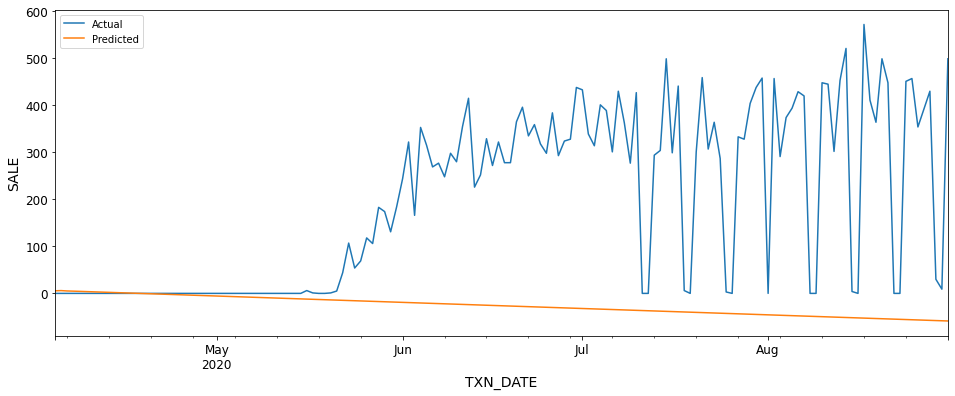

In [130]:
compare.plot(legend=True)
plt.ylabel('SALE')
plt.show()

In [131]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
print(f"ARIMA MAE : {mean_absolute_error(compare['Actual'],compare['Predicted'])}")
print(f"ARIMA MSE : {mean_squared_error(compare['Actual'],compare['Predicted'])}")

ARIMA MAE : 221.38043585604407
ARIMA MSE : 87617.02482439151


## EVALUATION ON MONTH WISE DATA

In [69]:
from pmdarima import auto_arima 

arima_model = auto_arima(month_data['PRODUCT_QUANTITY'],start_p=0,start_q=0,max_p=3,max_q=3,seasonal=False,trace=True,
                         error_action='ignore',suppress_warnings=True)
arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=840.359, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=765.314, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.62 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=767.311, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=767.406, Time=0.20 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.71 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=761.805, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=790.504, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=763.253, Time=0.44 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=763.403, Time=0.27 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=762.748, Time=0.75 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 4.050 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   38
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -377.903
Date:                Thu, 03 Dec 2020   AIC                            761.805
Time:                        00:30:15   BIC                            766.718
Sample:                             0   HQIC                           763.553
                                 - 38                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3108.6409   1468.804      2.116      0.034     229.837    5987.445
ar.L1          0.7496      0.086      8.758      0.000       0.582       0.917
sigma2      2.555e+07      0.244   1.05e+08      0.000    2.55e+07    2.55e+07
===================================================================================
Ljung-Box (Q):                       15.70   Jarque-Bera (JB):                72.77
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               5.46   Skew:                            -1.44
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.45e+24. Standard errors may be unstable.
"""

In [75]:
# Finding the split point index to keep 5 months data as test set
n_test = 5
train_data = month_data.iloc[:len(month_data) - n_test]
test_data = month_data.iloc[len(month_data) - n_test:]

In [76]:
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
model = ARIMA(train_data['PRODUCT_QUANTITY'],order=(1,0,0))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:       PRODUCT_QUANTITY   No. Observations:                   33
Model:                     ARMA(1, 0)   Log Likelihood                -328.060
Method:                       css-mle   S.D. of innovations           4969.571
Date:                Thu, 03 Dec 2020   AIC                            662.120
Time:                        00:33:22   BIC                            666.610
Sample:                    07-01-2017   HQIC                           663.631
                         - 03-01-2020                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   1.362e+04   2901.519      4.693      0.000    7929.817    1.93e+04
ar.L1.PRODUCT_QUANTITY     0.7225      0.113      6.380      0.000       0.501       0.944
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3841           +0.0000j            1.3841            0.0000
-----------------------------------------------------------------------------
"""

In [77]:
# Obtain predicted values on the test set
start = len(train_data)
end = len(train_data) + len(test_data) - 1
predictions = results.predict(start=start,end=end,dynamic=False,typ='levels').rename('ARIMA Predictions')

In [78]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted = {predictions[i]}, expected = {test_data['PRODUCT_QUANTITY'][i]}")

predicted = 10178.482630476687, expected = 0.0
predicted = 11132.546296426312, expected = 1183.0
predicted = 11821.868107767858, expected = 9337.0
predicted = 12319.910928755316, expected = 9199.0
predicted = 12679.752511389128, expected = 9454.0


In [79]:
compare = pd.DataFrame(columns=['Actual','Predicted'])

compare['Actual'] = test_data['PRODUCT_QUANTITY']
compare['Predicted'] = predictions

compare.head()

,Actual,Predicted
TXN_DATE,,
2020-04-01,0.0,10178.482630
2020-05-01,1183.0,11132.546296
2020-06-01,9337.0,11821.868108
2020-07-01,9199.0,12319.910929
2020-08-01,9454.0,12679.752511


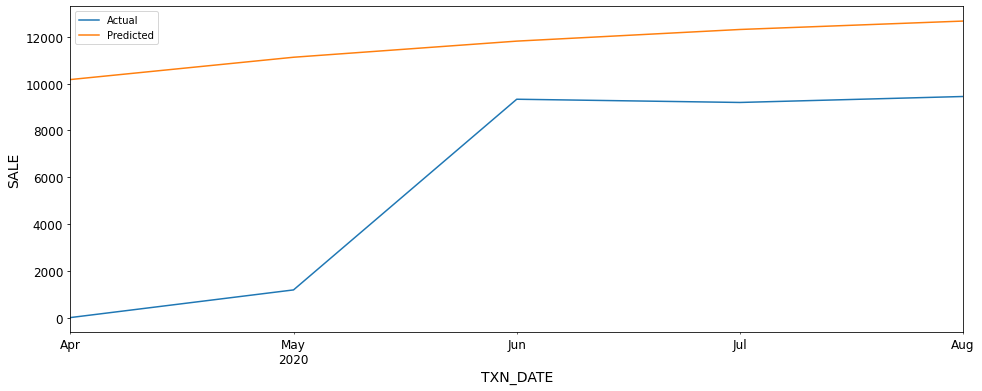

In [80]:
compare.plot(legend=True)
plt.ylabel('SALE')
plt.show()

In [81]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
print(f"SARIMA MAE : {mean_absolute_error(compare['Actual'],compare['Predicted'])}")
print(f"SARIMA MSE : {mean_squared_error(compare['Actual'],compare['Predicted'])}")

SARIMA MAE : 5791.912094963059
SARIMA MSE : 45783022.79332112


In [82]:
sarima_model = auto_arima(month_data['PRODUCT_QUANTITY'],start_p=0,start_q=0,max_p=3,max_q=3,start_P=0,start_Q=0,max_P=3,max_Q=3,m=12,seasonal=True,trace=True,stepwise=True,
           error_action='ignore',suppress_warnings=True)
sarima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=790.504, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=763.709, Time=0.65 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=1.02 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=840.359, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=761.805, Time=0.09 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=763.623, Time=0.20 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=765.510, Time=0.43 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=763.253, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=763.403, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=762.748, Time=0.47 sec
 ARIMA(1,0,0)(0,0,0)[12]             : AIC=765.314, Time=0.05 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 3.556 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   38
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -377.903
Date:                Thu, 03 Dec 2020   AIC                            761.805
Time:                        00:37:36   BIC                            766.718
Sample:                             0   HQIC                           763.553
                                 - 38                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3108.6409   1468.804      2.116      0.034     229.837    5987.445
ar.L1          0.7496      0.086      8.758      0.000       0.582       0.917
sigma2      2.555e+07      0.244   1.05e+08      0.000    2.55e+07    2.55e+07
===================================================================================
Ljung-Box (Q):                       15.70   Jarque-Bera (JB):                72.77
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               5.46   Skew:                            -1.44
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.45e+24. Standard errors may be unstable.
"""

In [83]:
# Finding the split point index to keep 5 months data as test set
n_test = 5
train_data = month_data.iloc[:len(month_data) - n_test]
test_data = month_data.iloc[len(month_data) - n_test:]

In [84]:
## best model is at ARIMA(1,0,0),(0,0,0,12)

from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_data['PRODUCT_QUANTITY'],order=(1,0,0),seasonal_order=(0,0,0,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       PRODUCT_QUANTITY   No. Observations:                   33
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -330.725
Date:                Thu, 03 Dec 2020   AIC                            665.451
Time:                        00:39:59   BIC                            668.444
Sample:                    07-01-2017   HQIC                           666.458
                         - 03-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9322      0.052     17.858      0.000       0.830       1.035
sigma2      2.808e+07   6.99e-10   4.02e+16      0.000    2.81e+07    2.81e+07
===================================================================================
Ljung-Box (Q):                       19.34   Jarque-Bera (JB):               143.81
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               8.16   Skew:                            -1.61
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.83e+31. Standard errors may be unstable.
"""

In [85]:
# Obtain predicted values on the test set
start = len(train_data)
end = len(train_data) + len(test_data) - 1
#print(end)
predictions = results.predict(start=start,end=end,dynamic=False,typ='levels').rename('SARIMA Predictions')

In [86]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted = {predictions[i]}, expected = {test_data['PRODUCT_QUANTITY'][i]}")

predicted = 8257.717048798804, expected = 0.0
predicted = 7698.113666518677, expected = 1183.0
predicted = 7176.433107654364, expected = 9337.0
predicted = 6690.1054439649615, expected = 9199.0
predicted = 6236.734904367934, expected = 9454.0


In [87]:


compare = pd.DataFrame(columns=['Actual','Predicted'])

compare['Actual'] = test_data['PRODUCT_QUANTITY']
compare['Predicted'] = predictions

compare.head()



,Actual,Predicted
TXN_DATE,,
2020-04-01,0.0,8257.717049
2020-05-01,1183.0,7698.113667
2020-06-01,9337.0,7176.433108
2020-07-01,9199.0,6690.105444
2020-08-01,9454.0,6236.734904


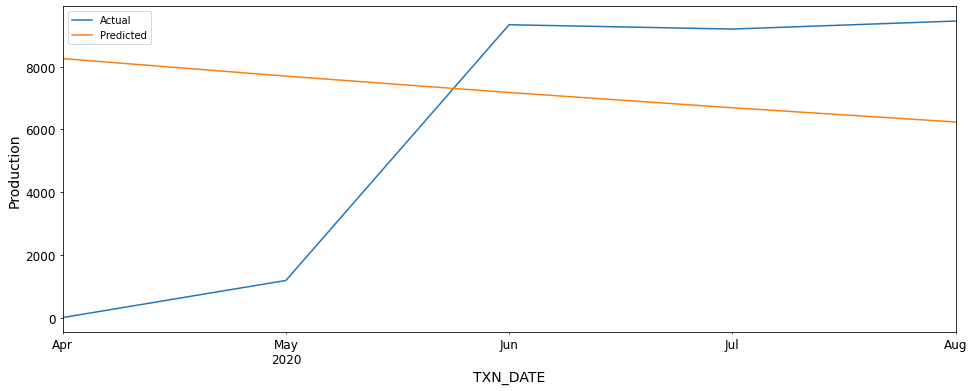

In [88]:
compare.plot(legend=True)
plt.ylabel('Production')
plt.show()

In [89]:


##Evaluate the Model


from sklearn.metrics import mean_squared_error,mean_absolute_error
print(f"SARIMA MAE : {mean_absolute_error(compare['Actual'],compare['Predicted'])}")
print(f"SARIMA MSE : {mean_squared_error(compare['Actual'],compare['Predicted'])}")



SARIMA MAE : 4531.911451866044
SARIMA MSE : 26389998.56617112


## EVALUATION ON WEEK WISE DATA

In [41]:
from pmdarima import auto_arima 

arima_model = auto_arima(week_data['PRODUCT_QUANTITY'],start_p=0,start_q=0,max_p=3,max_q=3,seasonal=False,trace=True,
                         error_action='ignore',suppress_warnings=True)
arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2678.313, Time=13.60 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2678.005, Time=1.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2677.755, Time=0.73 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2676.318, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2679.592, Time=0.40 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 17.846 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  167
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1337.159
Date:                Wed, 02 Dec 2020   AIC                           2676.318
Time:                        23:58:47   BIC                           2679.430
Sample:                             0   HQIC                          2677.581
                                - 167                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.775e+05   1.84e+04     31.386      0.000    5.41e+05    6.14e+05
===================================================================================
Ljung-Box (Q):                       54.18   Jarque-Bera (JB):              3299.08
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):               1.71   Skew:                            -2.12
Prob(H) (two-sided):                  0.05   Kurtosis:                        24.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [42]:
# Finding the split point index to keep 3 months i.e 12 weeks data as test set
n_test = 12
train_data = week_data.iloc[:len(week_data) - n_test]
test_data = week_data.iloc[len(week_data) - n_test:]

In [44]:
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
model = ARIMA(train_data['PRODUCT_QUANTITY'],order=(0,1,0))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:     D.PRODUCT_QUANTITY   No. Observations:                  154
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1242.697
Method:                           css   S.D. of innovations            773.188
Date:                Thu, 03 Dec 2020   AIC                           2489.394
Time:                        00:06:13   BIC                           2495.468
Sample:                    07-09-2017   HQIC                          2491.861
                         - 06-14-2020                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.1429     62.305      0.115      0.909    -114.973     129.259
==============================================================================
"""

In [45]:
# Obtain predicted values on the test set
start = len(train_data)
end = len(train_data) + len(test_data) - 1
predictions = results.predict(start=start,end=end,dynamic=False,typ='levels').rename('ARIMA Predictions')

In [46]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted = {predictions[i]}, expected = {test_data['PRODUCT_QUANTITY'][i]}")

predicted = 2081.1428571428573, expected = 2240.0
predicted = 2088.2857142857147, expected = 2311.0
predicted = 2095.428571428572, expected = 2642.0
predicted = 2102.5714285714294, expected = 1798.0
predicted = 2109.7142857142867, expected = 1843.0
predicted = 2116.857142857144, expected = 1721.0
predicted = 2124.0000000000014, expected = 2418.0
predicted = 2131.1428571428587, expected = 1908.0
predicted = 2138.285714285716, expected = 2173.0
predicted = 2145.4285714285734, expected = 2294.0
predicted = 2152.5714285714307, expected = 2123.0
predicted = 2159.714285714288, expected = 499.0


In [47]:
compare = pd.DataFrame(columns=['Actual','Predicted'])

compare['Actual'] = test_data['PRODUCT_QUANTITY']
compare['Predicted'] = predictions

compare.head()

,Actual,Predicted
TXN_DATE,,
2020-06-21,2240.0,2081.142857
2020-06-28,2311.0,2088.285714
2020-07-05,2642.0,2095.428571
2020-07-12,1798.0,2102.571429
2020-07-19,1843.0,2109.714286


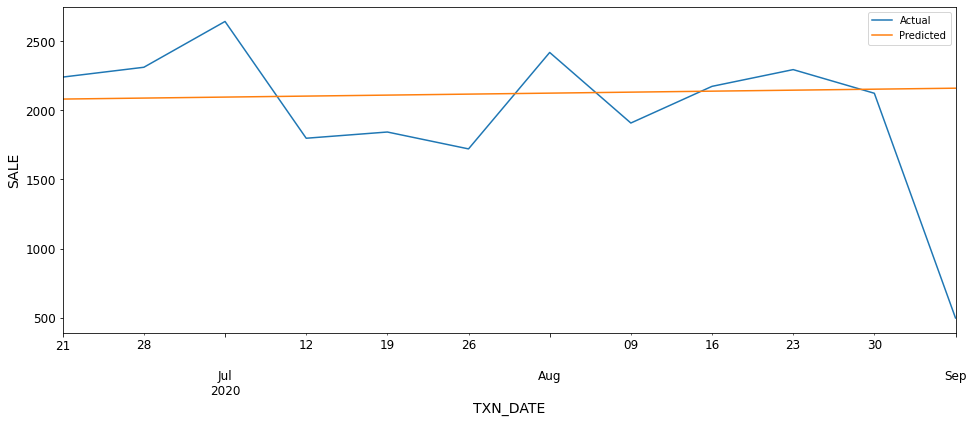

In [48]:
compare.plot(legend=True)
plt.ylabel('SALE')
plt.show()

In [49]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
print(f"SARIMA MAE : {mean_absolute_error(compare['Actual'],compare['Predicted'])}")
print(f"SARIMA MSE : {mean_squared_error(compare['Actual'],compare['Predicted'])}")

SARIMA MAE : 357.1666666666669
SARIMA MSE : 301044.53401360614




These are not good results as our model does not take the seasonality of the data into account.

Next we will look at our final model which is the Seasonal ARIMA.




# SARIMA



##### Seasonal Autoregressive Integrated Moving Averages

Where ARIMA accepts the parameters $(p,d,q)$, SARIMA accepts an additional set of parameters $(P,D,Q)m$ that specifically describe the seasonal components of the model. Here $P$, $D$ and $Q$ represent the seasonal regression, differencing and moving average coefficients, and $m$ represents the number of data points (rows) in each seasonal cycle.


In [50]:
sarima_model = auto_arima(week_data['PRODUCT_QUANTITY'],start_p=0,start_q=0,max_p=3,max_q=3,start_P=0,start_Q=0,max_P=3,max_Q=3,m=12,seasonal=True,trace=True,stepwise=True,
           error_action='ignore',suppress_warnings=True)
sarima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2678.313, Time=0.15 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2678.757, Time=3.53 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2678.450, Time=0.84 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2676.318, Time=0.05 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=2679.102, Time=0.52 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=2679.034, Time=0.46 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=2681.000, Time=1.10 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2678.005, Time=0.79 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=2677.755, Time=0.52 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=2679.592, Time=1.24 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 9.652 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  167
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1337.159
Date:                Thu, 03 Dec 2020   AIC                           2676.318
Time:                        00:13:21   BIC                           2679.430
Sample:                             0   HQIC                          2677.581
                                - 167                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.775e+05   1.84e+04     31.386      0.000    5.41e+05    6.14e+05
===================================================================================
Ljung-Box (Q):                       54.18   Jarque-Bera (JB):              3299.08
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):               1.71   Skew:                            -2.12
Prob(H) (two-sided):                  0.05   Kurtosis:                        24.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [59]:
# Finding the split point index to keep 3 months i.e 12 weeks data as test set
n_test = 12
train_data = week_data.iloc[:len(week_data) - n_test]
test_data = week_data.iloc[len(week_data) - n_test:]

In [60]:
test_data

,PRODUCT_QUANTITY
TXN_DATE,
2020-06-21,2240.0
2020-06-28,2311.0
2020-07-05,2642.0
2020-07-12,1798.0
2020-07-19,1843.0
2020-07-26,1721.0
2020-08-02,2418.0
2020-08-09,1908.0
2020-08-16,2173.0


In [61]:
## best model is at ARIMA(0,1,0),(0,0,0,12)

from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_data['PRODUCT_QUANTITY'],order=(0,1,0),seasonal_order=(0,0,0,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       PRODUCT_QUANTITY   No. Observations:                  155
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1242.705
Date:                Thu, 03 Dec 2020   AIC                           2487.410
Time:                        00:21:38   BIC                           2490.447
Sample:                    07-02-2017   HQIC                          2488.644
                         - 06-14-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       5.94e+05   1.95e+04     30.434      0.000    5.56e+05    6.32e+05
===================================================================================
Ljung-Box (Q):                       50.45   Jarque-Bera (JB):              3179.19
Prob(Q):                              0.12   Prob(JB):                         0.00
Heteroskedasticity (H):               3.75   Skew:                            -2.17
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [63]:
# Obtain predicted values on the test set
start = len(train_data)
end = len(train_data) + len(test_data) - 1
#print(end)
predictions = results.predict(start=start,end=end,dynamic=False,typ='levels').rename('SARIMA Predictions')

In [64]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted = {predictions[i]}, expected = {test_data['PRODUCT_QUANTITY'][i]}")

predicted = 2074.0, expected = 2240.0
predicted = 2074.0, expected = 2311.0
predicted = 2074.0, expected = 2642.0
predicted = 2074.0, expected = 1798.0
predicted = 2074.0, expected = 1843.0
predicted = 2074.0, expected = 1721.0
predicted = 2074.0, expected = 2418.0
predicted = 2074.0, expected = 1908.0
predicted = 2074.0, expected = 2173.0
predicted = 2074.0, expected = 2294.0
predicted = 2074.0, expected = 2123.0
predicted = 2074.0, expected = 499.0


In [65]:


compare = pd.DataFrame(columns=['Actual','Predicted'])

compare['Actual'] = test_data['PRODUCT_QUANTITY']
compare['Predicted'] = predictions

compare.head()



,Actual,Predicted
TXN_DATE,,
2020-06-21,2240.0,2074.0
2020-06-28,2311.0,2074.0
2020-07-05,2642.0,2074.0
2020-07-12,1798.0,2074.0
2020-07-19,1843.0,2074.0


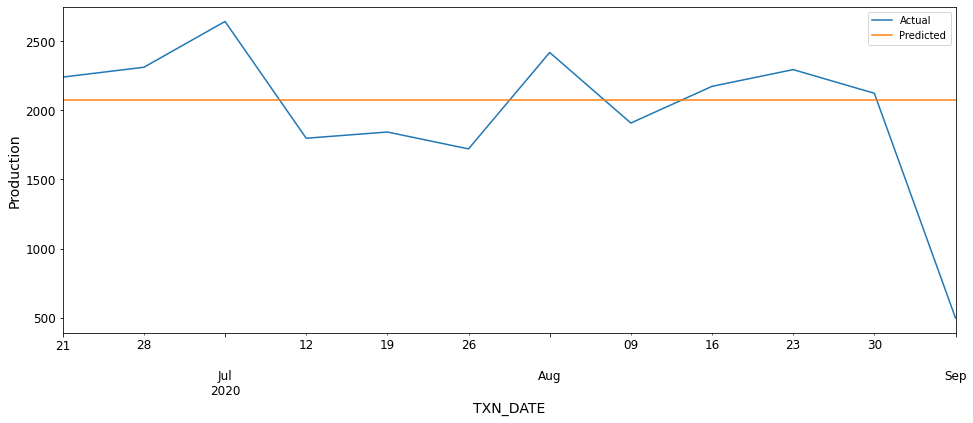

In [66]:
compare.plot(legend=True)
plt.ylabel('Production')
plt.show()

In [67]:


##Evaluate the Model


from sklearn.metrics import mean_squared_error,mean_absolute_error
print(f"SARIMA MAE : {mean_absolute_error(compare['Actual'],compare['Predicted'])}")
print(f"SARIMA MSE : {mean_squared_error(compare['Actual'],compare['Predicted'])}")



SARIMA MAE : 357.0
SARIMA MSE : 278967.8333333333


 First, we fit an ARIMA(5,1,0) model. This sets the lag value to 5 for autoregression, uses a difference order of 1 to make the time series stationary, and uses a moving average model of 0.

When fitting the model, a lot of debug information is provided about the fit of the linear regression model. We can turn this off by setting the disp argument to 0

                             ARIMA Model Results                              
Dep. Variable:     D.PRODUCT_QUANTITY   No. Observations:                   37
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -362.750
Method:                       css-mle   S.D. of innovations           4358.530
Date:                Wed, 02 Dec 2020   AIC                            739.501
Time:                        21:59:10   BIC                            750.777
Sample:                    08-01-2017   HQIC                           743.476
                         - 08-01-2020                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                     -155.6149    447.535     -0.348      0.728   -1032.768     721.538
ar.L1.D.PRODUCT_QUANTITY    -0.1134      0.164     -0.693      0.488      -0.434       0.

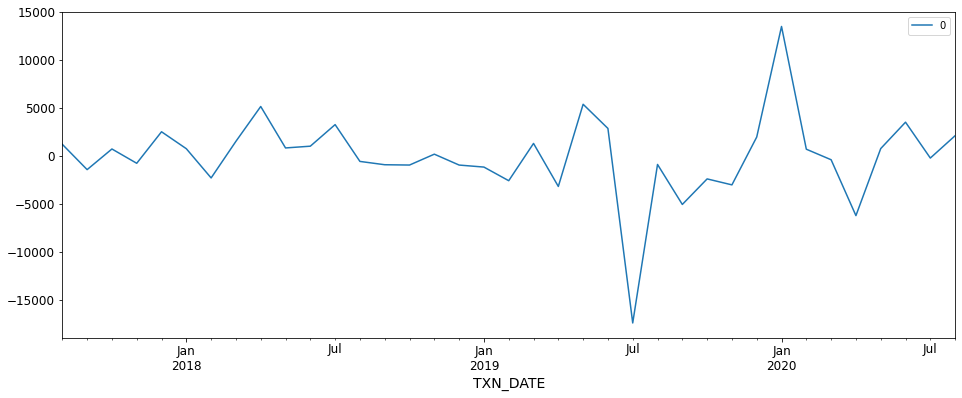

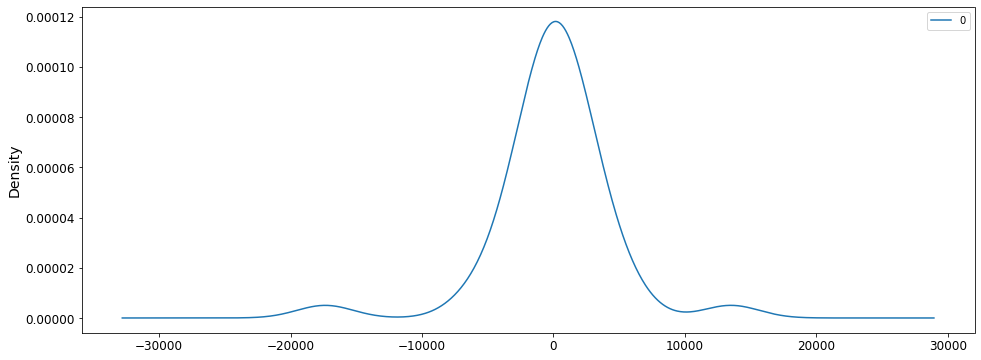

                  0
count     37.000000
mean      -4.431773
std     4420.432525
min   -17363.775296
25%    -1134.482285
50%      209.187108
75%     1547.659030
max    13503.542874


In [228]:
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
# fit model
model = ARIMA(month_data, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

First, we get a line plot of the residual errors, suggesting that there may still be some trend information not captured by the model.

Next, we get a density plot of the residual error values, suggesting the errors are Gaussian, but may not be centered on zero.

The distribution of the residual errors is displayed. The results show that indeed there is a bias in the prediction (a non-zero mean in the residuals)

In [231]:
month_data = month_data.replace(np.inf, np.nan).replace(-np.inf, np.nan).dropna()

X = month_data.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

LinAlgError: SVD did not converge

In [ ]:
## A line plot is created showing the expected values (blue) compared to the rolling forecast predictions (red). We can see the values show some trend and are in the correct scale.